In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import selfies as sf
import exmol
from dataclasses import dataclass
from rdkit.Chem.Draw import rdDepictor, MolsToGridImage
from rdkit.Chem import MolFromSmiles, MACCSkeys

rdDepictor.SetPreferCoordGen(True)
sns.set_context("notebook")
sns.set_style(
    "dark",
    {
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.color": "#666666",
        "ytick.color": "#666666",
        "axes.edgecolor": "#666666",
        "axes.linewidth": 0.8,
        "figure.dpi": 300,
    },
)
color_cycle = ["#F06060", "#1BBC9B", "#F06060", "#5C4B51", "#F3B562", "#6e5687"]
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=color_cycle)
mpl.rcParams["font.size"] = 12
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv"
)
features_start_at = list(soldata.columns).index("MolWt")
np.random.seed(0)

In [2]:
# scramble them
soldata = soldata.sample(frac=1, random_state=1).reset_index(drop=True)
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-4617,sodium heptadecyl sulfate,InChI=1S/C17H36O4S.Na/c1-2-3-4-5-6-7-8-9-10-11...,HHURSJAUVYNJBT-UHFFFAOYSA-M,[Na+].CCCCCCCCCCCCCCCCCO[S]([O-])(=O)=O,-2.366993,0.00000,1,G1,358.520,...,17.0,134.0,0.0,0.0,0.0,0.0,66.43,165.942910,0.000000,320.555057
1,B-738,n-decane,"InChI=1S/C10H22/c1-3-5-7-9-10-8-6-4-2/h3-10H2,...",DIOQZVSQGTUSAI-UHFFFAOYSA-N,CCCCCCCCCC,-6.437200,0.00000,1,G1,142.286,...,7.0,62.0,0.0,0.0,0.0,0.0,0.00,66.023730,2.647605,40.000000
2,B-4109,"2,4,5,2',5'-pcb",InChI=1S/C12H5Cl5/c13-6-1-2-9(14)7(3-6)8-4-11(...,LAHWLEDBADHJGA-UHFFFAOYSA-N,Clc1ccc(Cl)c(c1)c2cc(Cl)c(Cl)cc2Cl,-7.326300,0.28185,2,G3,326.437,...,1.0,88.0,2.0,0.0,0.0,2.0,0.00,124.004828,2.677954,577.348938
3,D-1712,"butanoic acid, pentyl ester",InChI=1S/C9H18O2/c1-3-5-6-8-11-9(10)7-4-2/h3-8...,CFNJLPHOBMVMNS-UHFFFAOYSA-N,CCCCCOC(=O)CCC,-2.467000,0.47710,2,G3,158.241,...,6.0,66.0,0.0,0.0,0.0,0.0,26.30,68.933855,3.040426,99.735855
4,B-4145,3-methylacetanilide,InChI=1S/C9H11NO/c1-7-4-3-5-9(6-7)10-8(2)11/h3...,ALMHSXDYCFOZQD-UHFFFAOYSA-N,CC(=O)Nc1cccc(C)c1,-2.091000,0.00000,1,G1,149.193,...,1.0,58.0,1.0,0.0,0.0,1.0,29.10,66.237614,2.790931,268.020173


In [3]:
selfies_list = [sf.encoder(exmol.sanitize_smiles(s)[1]) for s in soldata.SMILES]
len(selfies_list)

9982

In [4]:
basic = set(exmol.get_basic_alphabet())
data_vocab = set(
    sf.get_alphabet_from_selfies([s for s in selfies_list if s is not None])
)
vocab = ['[nop]']
vocab.extend(list(data_vocab.union(basic)))
vocab_stoi = {o: i for o, i in zip(vocab, range(len(vocab)))}


def selfies2ints(s):
    result = []
    for token in sf.split_selfies(s):
        if token == '.':
            continue  # ?
        if token in vocab_stoi:
            result.append(vocab_stoi[token])
        else:
            result.append(np.nan)
            # print('Warning')
    return result


def ints2selfies(v):
    return "".join([vocab[i] for i in v])


# test them out
s = selfies_list[0]
print('selfies:', s)
v = selfies2ints(s)
print('selfies2ints:', v)
so = ints2selfies(v)
print('ints2selfes:', so)
assert so == s.replace(
    '.', ''
)  # make sure '.' is removed from Selfies string during assertion

selfies: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][O][S][Branch1_2][C][=O][Branch1_2][C][=O][O-expl].[Na+expl]
selfies2ints: [46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 94, 76, 199, 46, 123, 199, 46, 123, 105, 55]
ints2selfes: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][O][S][Branch1_2][C][=O][Branch1_2][C][=O][O-expl][Na+expl]


In [5]:
#creating an object
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int
    hidden_dim: int


config = Config(
    vocab_size=len(vocab),
    example_number=len(selfies_list),
    batch_size=16,
    buffer_size=10000,
    embedding_dim=256,
    hidden_dim=128,
    rnn_units=128,
)

In [6]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list if s is not None]
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding="post")

# Now build dataset
data = tf.data.Dataset.from_tensor_slices(
    (padded_seqs, soldata.Solubility.iloc[[bool(s) for s in selfies_list]].values)
)
# now split into val, test, train and batch
N = len(data)
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), nontest.skip(
    split
).shuffle(config.buffer_size).batch(config.batch_size).prefetch(
    tf.data.experimental.AUTOTUNE
)

In [7]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(
    tf.keras.layers.Embedding(
        input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True
    )
)

# RNN layer
model.add(tf.keras.layers.GRU(config.rnn_units))
# a dense hidden layer
model.add(tf.keras.layers.Dense(config.hidden_dim, activation="relu"))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         54528     
_________________________________________________________________
gru (GRU)                    (None, 128)               148224    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 219,393
Trainable params: 219,393
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(tf.optimizers.Adam(1e-4), loss='mean_squared_error')
result = model.fit(train_data, validation_data=val_data, epochs=100, verbose=2)

Epoch 1/100
500/500 - 5s - loss: 4.6926 - val_loss: 3.0427
Epoch 2/100
500/500 - 4s - loss: 2.5597 - val_loss: 2.5474
Epoch 3/100
500/500 - 4s - loss: 2.3731 - val_loss: 2.3100
Epoch 4/100
500/500 - 4s - loss: 2.2485 - val_loss: 2.2012
Epoch 5/100
500/500 - 4s - loss: 2.1865 - val_loss: 2.1756
Epoch 6/100
500/500 - 4s - loss: 2.1187 - val_loss: 2.1893
Epoch 7/100
500/500 - 4s - loss: 2.0634 - val_loss: 2.1070
Epoch 8/100
500/500 - 4s - loss: 2.0045 - val_loss: 2.1195
Epoch 9/100
500/500 - 4s - loss: 1.9741 - val_loss: 2.0868
Epoch 10/100
500/500 - 4s - loss: 1.9204 - val_loss: 2.0068
Epoch 11/100
500/500 - 4s - loss: 1.8698 - val_loss: 1.9773
Epoch 12/100
500/500 - 4s - loss: 1.8460 - val_loss: 1.9875
Epoch 13/100
500/500 - 4s - loss: 1.8143 - val_loss: 1.9289
Epoch 14/100
500/500 - 4s - loss: 1.7547 - val_loss: 2.0842
Epoch 15/100
500/500 - 4s - loss: 1.7242 - val_loss: 1.9048
Epoch 16/100
500/500 - 4s - loss: 1.6868 - val_loss: 1.8558
Epoch 17/100
500/500 - 4s - loss: 1.6472 - val_lo

In [9]:
model.save('solubility-rnn-accurate')
# model = tf.keras.models.load_model('solubility-rnn-accurate/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: solubility-rnn-accurate/assets


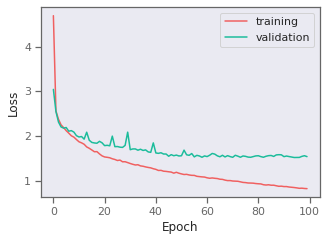

In [10]:
plt.figure(figsize=(5,3.5))
plt.plot(result.history['loss'], label='training')
plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('rnn-loss.png', bbox_inches="tight", dpi=300)
plt.show()

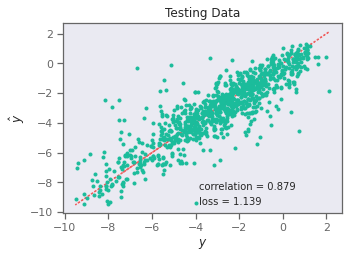

In [11]:
yhat = []
test_y = []
for x,y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

# plot test data
plt.figure(figsize=(5,3.5))
plt.plot(test_y, test_y, ':')
plt.plot(test_y, yhat, '.')
plt.text(max(test_y) - 6, min(test_y) + 1, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(max(test_y) - 6, min(test_y), f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.xlabel(r'$y$')
plt.ylabel(r'$\hat{y}$')
plt.title('Testing Data')
plt.savefig('rnn-fit.png', dpi=300, bbox_inches='tight')
plt.show()


### Description of AqSolDB data

Compounds can be classified according to solubility values (LogS); Compounds with 0 and higher solubility value are highly soluble, those in the range of 0 to −2 are soluble, those in the range of −2 to −4 are slightly soluble and insoluble if less than −4.

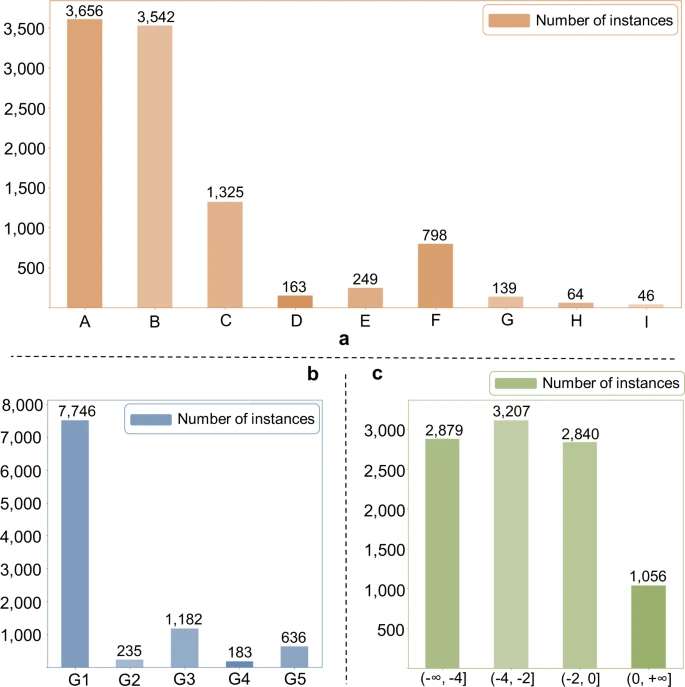

In [12]:
idx = np.argsort(soldata.Solubility)
idx[-40:]

9942    9934
9943      94
9944    5883
9945    4435
9946    1111
9947    2817
9948    6459
9949    4811
9950    2838
9951    8672
9952    8478
9953    2857
9954    9471
9955    7681
9956    6152
9957    8711
9958    6224
9959    6415
9960    8932
9961    9837
9962    3614
9963    6611
9964     944
9965    5114
9966    3985
9967    1835
9968    6760
9969    8357
9970    4102
9971    5004
9972    9588
9973    1329
9974    4578
9975     581
9976      95
9977    6186
9978    5532
9979    8288
9980     228
9981     314
Name: Solubility, dtype: int64

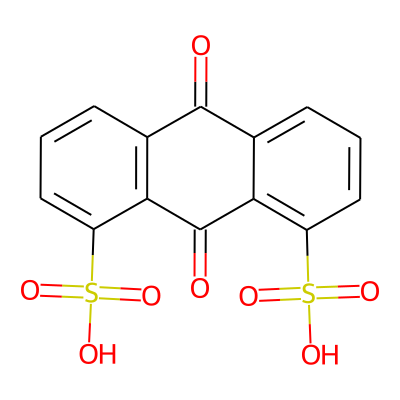

In [27]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole, SetComicMode
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from copy import deepcopy

SetComicMode(IPythonConsole.drawOptions)
mol = MolFromSmiles(soldata.SMILES[5883])
d2d = rdMolDraw2D.MolDraw2DSVG(400, 400)
d2d.drawOptions().comicMode = True
d2d.SetFontSize(0.75)
d2d.drawOptions().addAtomIndices = True
d2d.DrawMolecule(mol)
d2d.FinishDrawing()
text2 = d2d.GetDrawingText()

with open('atom_annotation.svg', 'w') as f:
    f.write(text2)

SVG(d2d.GetDrawingText())

## LIME explanations

In the following example, we find out what descriptors influence solubility of a molecules. For example, let's say we have a molecule with LogS=1.5. We create a perturbed chemical space around that molecule using `stoned` method and then use `lime` to find out which descriptors affect solubility predictions for that molecule. 

### Define functions used for this method

In [21]:
# Predictor function is used as input to sample_space function
def predictor_function(smile_list,selfies):
    encoded = [selfies2ints(s) for s in selfies]
    # check for nans
    valid = [1. if sum(e) > 0 else np.nan for e in encoded]
    encoded = [np.nan_to_num(e, nan=0) for e in encoded]
    padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')
    labels = np.reshape(model.predict(padded_seqs), (-1))
    return labels * valid

In [22]:
# Gives indices for descriptor names
def feature_dict(space):
    features = {a: b for a, b in zip(space[0].descriptors.descriptor_names, 
                                     np.arange(len(space[0].descriptors.descriptors)))}
    return features

In [18]:
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib.offsetbox import AnnotationBbox
import textwrap
import skunk

def plot_desc(feature_importance, desc_type, output_file, title=None, ax = None, T=None):
    t = [a[0] for a in list(feature_importance.values()) if not np.isnan(a[0])][:5]
    key_ids = [a[1] for a in list(feature_importance.values()) if not np.isnan(a[0])][:5]
    keys = [a for a in list(feature_importance.keys()) if not np.isnan(feature_importance[a][0])]
    
    colors = []
    for ti in t:
        if ti < 0:
            colors.append(color_cycle[0])
        if ti > 0:
            colors.append(color_cycle[1])

    if len(t) > 0:
        if len(t) > 5:
            t = t[:5]
            keys = keys[:5]
            print(t)
        elif len(t) < 5:
            diff = 5 - len(t)
            for i in range(diff):
                t.append(0)
                keys.append(' ')
        bar1 = ax.barh(range(len(t)), t, color=colors, height=0.75)
        new_patches = []
        for patch in reversed(ax.patches):
            bb = patch.get_bbox()
            color=patch.get_facecolor()
            p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                                abs(bb.width), abs(bb.height),
                                boxstyle="round,pad=-0.040,rounding_size=0.015",
                                ec="none", fc=color,
                                mutation_aspect=4
                                )
            patch.remove()
            new_patches.append(p_bbox)
        for patch in new_patches:
            ax.add_patch(patch)

        
        count = 0
        sk_dict = {}
        for rect, ti, k in zip(bar1, t, keys):
            y = rect.get_y() + rect.get_height()/2.
            if len(k) > 60:
                k = textwrap.fill(k, 25)
            elif len(k) > 25:
                k = textwrap.fill(k, 20)
            if ti < 0:
                x = 0.25
                skx = np.max(np.absolute(t)) + 2
                box_x = 0.98
                ax.text(x, y, k, ha='left', va='center', wrap=True, fontsize=12)
            else:
                x = - 0.25
                skx = - np.max(np.absolute(t)) - 2
                box_x = 0.02
                ax.text(x, y, k, ha='right', va='center', wrap=True, fontsize=12)
            if desc_type == 'MACCS':
                box = skunk.Box(130, 50, f'sk{count}')
                
                ab = AnnotationBbox(box, xy=(skx, count),
                                    xybox=(box_x, (5 - count)*0.2 - 0.1), #Invert axis
                                    xycoords='data',
                                    boxcoords='axes fraction',
                                    bboxprops=dict(lw=0.5))
                                 
                
                ax.add_artist(ab)
                sk_dict[f'sk{count}'] = f'keys/{key_ids[count]}.svg'
            
            count+=1
        
        ax.axvline(x=0, color='grey', linewidth=0.5)
        if T is not None:
            ax.axvline(x=T, color='#f5ad4c', linewidth=0.75, linestyle='--', zorder=0)
            ax.axvline(x=-T, color='#f5ad4c', linewidth=0.75, linestyle='--', zorder=0)
        ax.set_yticks([])
        ax.invert_yaxis()
        ax.set_xlabel('Descriptor t-statistics', fontsize=12)
        ax.set_title(title, fontsize=12)
        if desc_type=='MACCS':
            ax.set_xlim(-np.max(np.absolute(t))-5, np.max(np.absolute(t))+5)
            svg = skunk.insert(sk_dict)
            plt.tight_layout()
            if output_file is not None:
                with open(output_file, 'w') as f:
                    f.write(svg)
        else:
            ax.set_xlim(-max(np.max(np.absolute(t)), T+1), max(np.max(np.absolute(t)), T+1))
            plt.tight_layout()
            if output_file is not None:
                plt.savefig(output_file, dpi = 300, bbox_inches='tight')
        
    else:
        patch = ax.get_ylim()
        print(patch)
        ax.text(0.5, 0.5, 'No significant t-stats', ha='right', va='center', wrap=True, fontsize=8)
        ax.axvline(x=0, color='grey', linewidth=0.5)
        ax.set_yticks([])
        ax.invert_yaxis()
        ax.set_xlabel('Descriptor t-statistics', fontsize=10)
        ax.set_title(title, fontsize=10)
        if output_file is not None:
            plt.savefig(output_file, dpi = 300, bbox_inches='tight')

In [19]:
from typing import *
from exmol.plot_utils import _mol_images, _image_scatter
from exmol.data import Example

def plot_space_by_fit(
    examples: List[Example],
    exps: List[Example],
    beta: List = None,
    figure_kwargs: Dict = None,
    colorbar: bool=True,
    mol_size: Tuple[int, int] = (200, 200),
    highlight_clusters: bool = False,
    mol_fontsize: int = 8,
    offset: int = 0,
    ax: Any = None,
    cartoon: bool = False,
    rasterized: bool = False,
):
    """Plot chemical space around example by LIME fit and annotate given examples.
    :param examples: Large list of :obj:Example which make-up points
    :param exps: Small list of :obj:Example which will be annotated
    :param figure_kwargs: kwargs to pass to :func:`plt.figure<matplotlib.pyplot.figure>`
    :param mol_size: size of rdkit molecule rendering, in pixles
    :param highlight_clusters: if `True`, cluster indices are rendered instead of :obj:Example.yhat
    :param mol_fontsize: minimum font size passed to rdkit
    :param offset: offset annotations to allow colorbar or other elements to fit into plot.
    :param ax: axis onto which to plot
    :param cartoon: do cartoon outline on points?
    :param rasterized: raster the scatter?
    """
    imgs = _mol_images(exps, mol_size, mol_fontsize)
    if figure_kwargs is None:
        figure_kwargs = {"figsize": (12, 8)}
    base_color = "gray"
    if ax is None:
        ax = plt.figure(**figure_kwargs).gca()
    if highlight_clusters:
        colors = [e.cluster for e in examples]
        def normalizer(x):
            return x
        cmap = "Accent"
        
    if beta is None:
        raise ValueError('beta must be provided to plot by fit')
    yhat = [e.yhat for e in examples]
    yhat -= np.mean(yhat)
    x_mat = np.array([list(e.descriptors.descriptors)
                        for e in examples]).reshape(len(examples), -1)
    y = x_mat @ beta
    # use resids as colors
    colors = (yhat - y)**2
    normalizer = plt.Normalize(min(colors), max(colors))
    cmap = "PuBu_r"

    space_x = [e.position[0] for e in examples]
    space_y = [e.position[1] for e in examples]
    if cartoon:
        # plot shading, lines, front
        ax.scatter(space_x, space_y, 50, "0.0", lw=2, rasterized=rasterized)
        ax.scatter(space_x, space_y, 50, "1.0", lw=0, rasterized=rasterized)
        ax.scatter(
            space_x,
            space_y,
            50,
            c=normalizer(colors),
            cmap=cmap,
            lw=2,
            alpha=0.1,
            rasterized=rasterized,
        )
    else:
        im = ax.scatter(
                space_x,
                space_y,
                40,
                c=normalizer(colors),
                cmap=cmap,
                edgecolors="grey",
                linewidth=0.25
            )
    if colorbar:
        ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
        cbar = plt.colorbar(im, orientation="horizontal", aspect=35, pad=0.05)
        cbar.set_label('squared error')

    # now plot cfs/annotated points
    ax.scatter(
        [e.position[0] for e in exps],
        [e.position[1] for e in exps],
        c=normalizer([e.cluster if highlight_clusters else e.yhat for e in exps]),
        cmap=cmap,
        edgecolors="black",
    )

    x = [e.position[0] for e in exps]
    y = [e.position[1] for e in exps]
    titles = []
    colors = []
    for e in exps:
        if not e.is_origin:
            titles.append(f"Similarity = {e.similarity:.2f}\nf(x)={e.yhat:.3f}")
            colors.append(cast(Any, base_color))
        else:
            titles.append(f"Base \nf(x)={e.yhat:.3f}")
            colors.append(cast(Any, base_color))
    _image_scatter(x, y, imgs, titles, colors, ax, offset=offset)
    ax.axis("off")
    ax.set_aspect("auto")


In [ ]:
def lime_explain(examples: List[Example], descriptor_type: str) -> np.ndarray:
    """From given :obj:`Examples<Example>`, find descriptor t-statistics (see
    :doc: `index`)

    :param examples: Output from :func: `sample_space`
    :param descriptor_type: Desired descriptors, choose from `Classic` or `MACCS`
    """
    examples = get_descriptors(examples, descriptor_type)
    # weighted tanimoto similarities
    w = np.array([1/(1 + (1/(e.similarity + 0.000001) - 1)**5)
                  for e in examples])
    nonzero_w = w[np.nonzero(w)]
    # create a diagonal matrix of w
    N = nonzero_w.shape[0]
    diag_w = np.zeros((N, N))
    np.fill_diagonal(diag_w, w)
    # get feature matrix 
    x_mat = np.array([list(e.descriptors.descriptors)
                      for e in examples])[nonzero_w].reshape(len(examples), -1)
    # remove zero variance columns
    y = np.array([e.yhat for e in examples]).reshape(
        len(examples)).astype(float)
    # remove bias
    y -= np.mean(y)
    # compute least squares fit
    xtinv = np.linalg.pinv((x_mat.T @ diag_w @ x_mat ))
    beta = xtinv @ x_mat.T @ (y * w)
    # compute tstats for each example as a difference from base
    for e in examples:
        e.descriptors.tstats = e.descriptors.descriptors * beta
    # compute standard error in beta
    yhat = x_mat @ beta
    resids = yhat - y
    SSR = np.sum(resids**2)
    se2_epsilon = SSR / (len(examples) - len(beta))
    se2_beta = se2_epsilon * xtinv
    # now compute t-statistic for existence of coefficients
    tstat = beta * np.sqrt(1 / np.diag(se2_beta))
    # Return tstats of the space and beta (feature weights) which are the fits
    return tstat, beta

## Plot WLS Fit and show which MACCS keys matter for CFs

In [21]:
stoned_kwargs={'num_samples': 2500, 'alphabet':exmol.get_basic_alphabet(), 'max_mutations': 1}
space = exmol.sample_space(soldata.SMILES[5883], predictor_function, stoned_kwargs=stoned_kwargs)
# 3826 is a highly soluble compound

🤘Done🤘: 100%|██████████| 1535.0/1535 [00:04<00:00, 319.92it/s]                      


In [22]:
# compute effective sample size
w = np.array([1/(1 + (1/(e.similarity + 0.000001) - 1)**5) for e in space]) 
w = w/np.sum(w)
effective_n = np.sum(w) ** 2 / np.sum(w ** 2)
effective_n, len(space)

(422.32568719145695, 1535)

Classic
T = 1.9655970039863828


/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply


MACCS
T = 1.9655970039863828


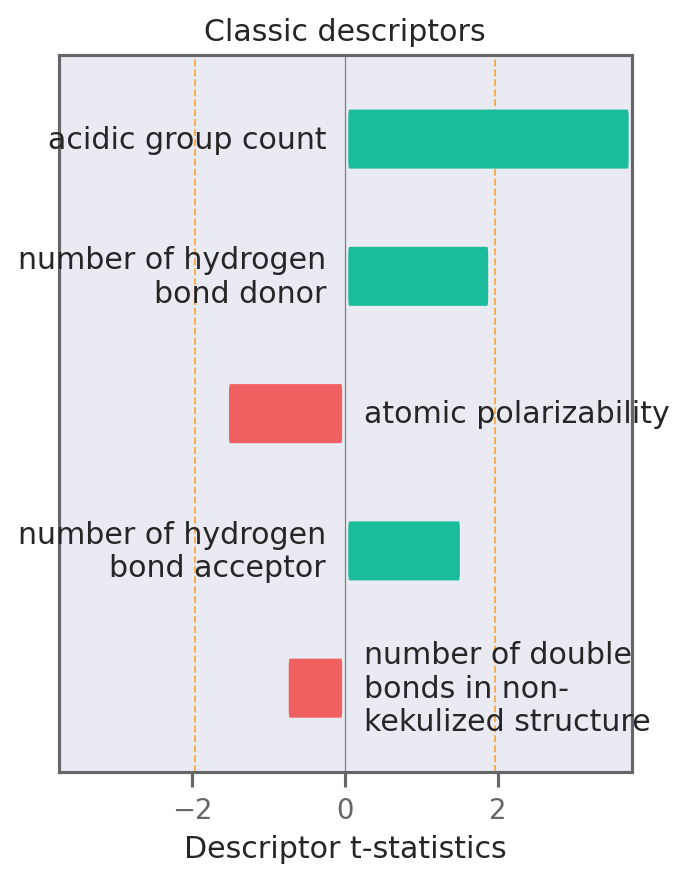

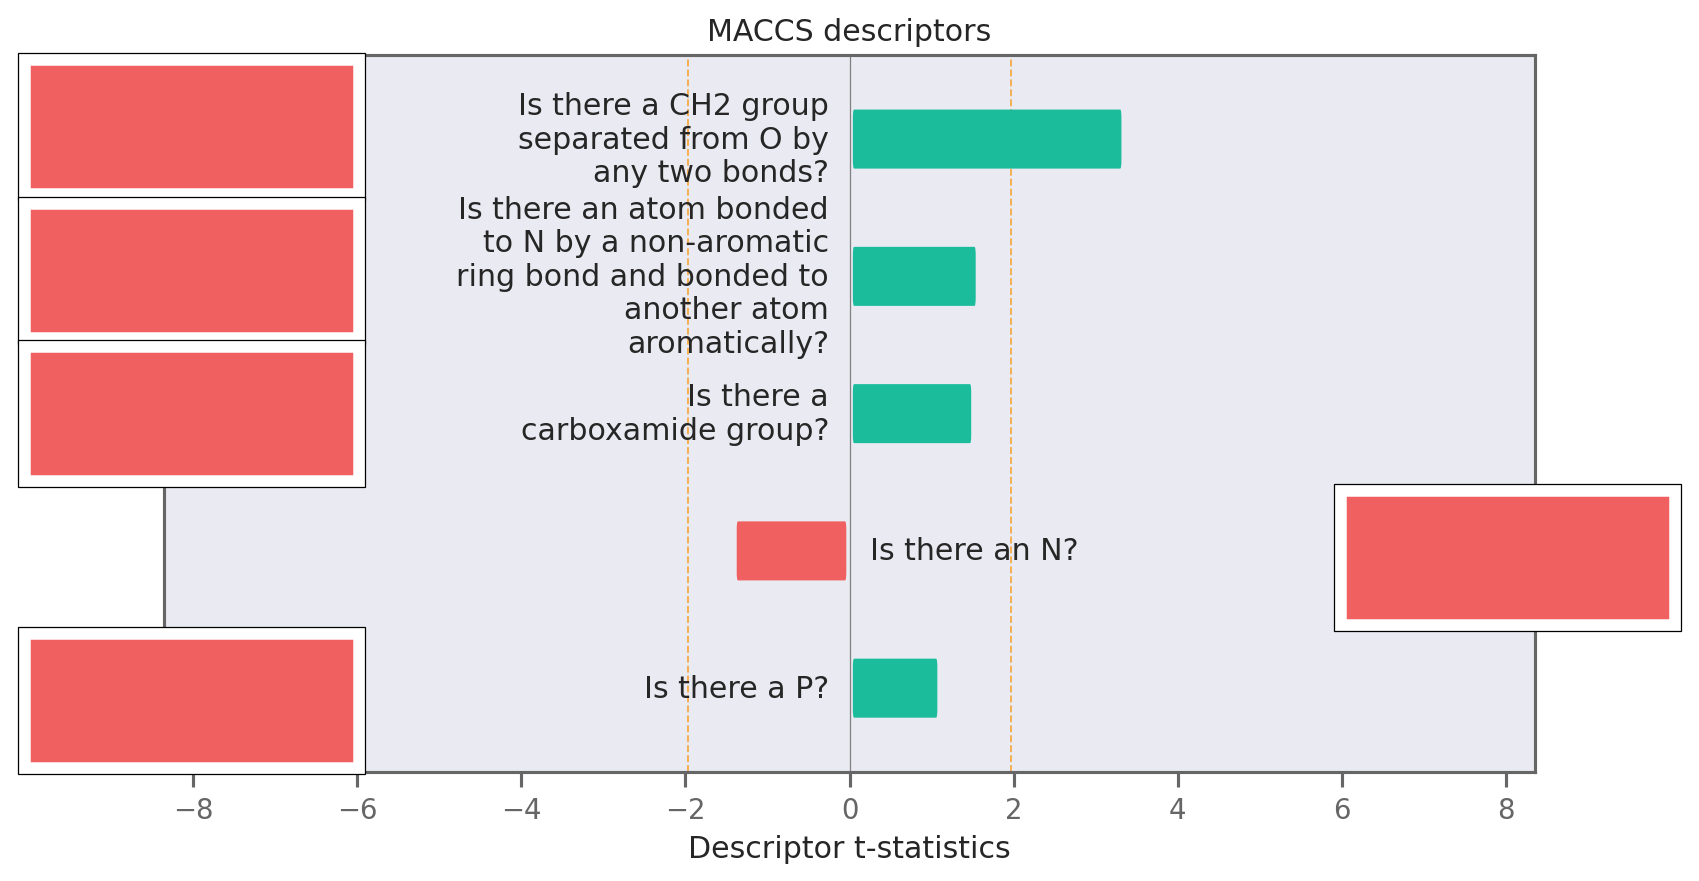

In [23]:
from mordred import HydrogenBond, Polarizability
from mordred import SLogP, AcidBase, BertzCT, Aromatic, BondCount
from mordred import Calculator
import scipy.stats as ss

%matplotlib inline

desc_type = ['Classic', 'MACCS']

for d in desc_type:
    if d == 'Classic':
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,5), dpi=180)
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5), dpi=180)
    
    # get sample t-stats
    space_tstats, beta = exmol.lime_explain(space, descriptor_type=d)
    
    # compute significant t-stat
    T = ss.t.ppf( 0.975, df = effective_n)
    print(f'{d}\nT = {T}')
    
    # Get feature importance
    feature_importance = {a: [b, i] for i, a, b in zip(np.arange(len(space[0].descriptors.descriptors)), 
                                                       space[0].descriptors.descriptor_names, 
                                                       space_tstats) if not np.isnan(b)}
    feature_importance = dict(sorted(feature_importance.items(),
                     key=lambda item: abs(item[1][0]),
                     reverse=True))
    # Plot
    plot_desc(feature_importance, d, output_file=f'desc_{d}.svg', 
                  ax=ax, title=f'{d} descriptors', T=T)

plt.show()

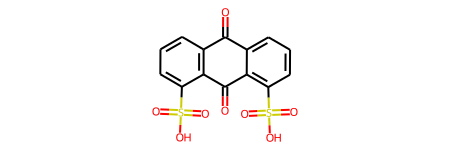

In [124]:
from rdkit.Chem.Draw import MolToFile, MolToSVG
smi = soldata.SMILES[1241]
# MolToFile(MolFromSmiles(smi), 'mol_3826.svg', (300,300))
MolFromSmiles(soldata.SMILES[5883])#, soldata.Solubility[3826]

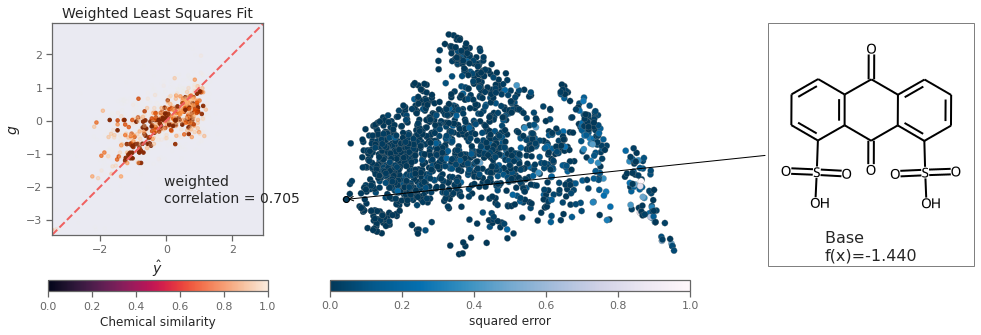

In [24]:
fkw = {'figsize': (6,4)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

fig = plt.figure(figsize=(10,5))
mpl.rc('axes', titlesize=12)
mpl.rc('font', size=16)
ax_dict = fig.subplot_mosaic('AABBB')

svg = plot_space_by_fit(space, [space[0]], figure_kwargs=fkw, 
                        mol_size=(200,200), offset=1, 
                        ax=ax_dict['B'], 
                        beta=beta)

ys = [e.yhat for e in space]
ys -= np.mean(ys)
x_mat = np.array([list(e.descriptors.descriptors)
                  for e in space]).reshape(len(space), -1)
y_wls = x_mat @ beta

lower = np.min(ys)
higher = np.max(ys)

# w = np.array([e.similarity for e in space])
# Another weighting scheme that produces s-curve: s = 1 / (1 + np.exp(-15 * (x-0.5) ))
w = np.array([1/(1 + (1/(e.similarity + 0.000001) - 1)**5) for e in space])

import matplotlib.colors as colors
normalizer = plt.Normalize(min(w), max(w))
cmap = plt.cm.Oranges(w)
cmap[:, -1] = w

def weighted_mean(x, w):
    return np.sum(x*w)/np.sum(w)
def weighted_cov(x, y, w):
    return np.sum(w * (x - weighted_mean(x, w)) * (y - weighted_mean(y, w))) / np.sum(w)
def weighted_correlation(x, y, w):
    return weighted_cov(x, y, w) / np.sqrt(weighted_cov(x, x, w) * weighted_cov(y, y, w))

corr = weighted_correlation(ys, y_wls, w)

ax_dict['A'].plot(np.linspace(lower, higher, 100), np.linspace(lower, higher, 100), '--', linewidth=2)
sc = ax_dict['A'].scatter(ys, y_wls, s=50, marker='.', c=cmap, cmap=cmap) # c=normalizer(w), cmap=cmap, lw=0.1, edgecolor='k')
# ax_dict['A'].text(max(ys) - 3, min(ys) + 1, f'correlation = {corr:.3f}', fontsize=14)
ax_dict['A'].text(max(ys) - 3, min(ys) + 1, f'weighted \ncorrelation = {corr:.3f}', fontsize=14)
ax_dict['A'].set_xlabel(r'$\hat{y}$', fontsize=14)
ax_dict['A'].set_ylabel(r'$g$', fontsize=14)
ax_dict['A'].set_title('Weighted Least Squares Fit', fontsize=14)
ax_dict['A'].set_xlim(lower, higher)
ax_dict['A'].set_ylim(lower, higher)
ax_dict['A'].set_aspect(1.0/ax_dict['A'].get_data_ratio(), adjustable='box')
cbar = plt.colorbar(sc, orientation="horizontal", pad=0.15, ax=ax_dict['A'])
cbar.set_label('Chemical similarity')
plt.tight_layout()
plt.savefig('Figure_1.svg', dpi=300, bbox_inches="tight", transparent=False)

# Is the correlation low because we added noise to x?

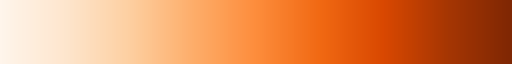

In [73]:
plt.cm.Oranges

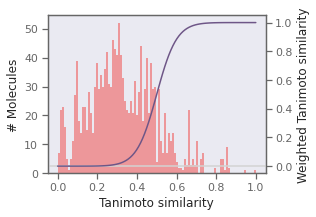

In [41]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(4.5,3))
ax1.hist([e.similarity for e in space], bins=99, edgecolor='none', label=d, alpha=0.6)
ax1.set_ylabel('# Molecules')
ax1.set_xlabel('Tanimoto similarity')

ax2 = ax1.twinx()

x = np.linspace(0,1,99)
y = 1/(1 + (1/(x + 0.000001) - 1)**5) 
ax2.set_ylabel('Weighted Tanimoto similarity')
ax2.axhline(y=0, color='lightgray', zorder=0)
ax2.plot(x, y, color=color_cycle[5], label='Sigmoid weights')

plt.tight_layout()
plt.savefig('sigmoid_weighting.png', bbox_inches='tight', dpi=300)
plt.show()

In [27]:
#Down sample to see all aliphatic compounds
chain_compounds = []
csmiles = []
for s in space:
    d = s.descriptors.descriptors
#     if or d[125]==1 or d[114]==1 or d[115]==1"
    if d[164]!=1  or d[162]!=1:
        chain_compounds.append(s)
        csmiles.append(s.smiles)
        
len(chain_compounds)

625

In [28]:
mols_10_atoms = []
for s in space:
    mol = MolFromSmiles(s.smiles)
    if len(mol.GetAtoms())<10:
        mols_10_atoms.append(s)
        
len(mols_10_atoms)

109

## Robustness to chemical space

In [169]:
stoned_kwargs={'num_samples': 10000, 'alphabet':exmol.get_basic_alphabet(), 'max_mutations': 2}
space = exmol.sample_space(soldata.SMILES[1200], predictor_function, stoned_kwargs=stoned_kwargs)
# 3826 is a highly soluble compound

🤘Done🤘: 100%|██████████| 3997.0/3997 [00:21<00:00, 183.19it/s]                        


In [170]:
MolFromSmiles(soldata.SMILES[1200]), soldata.Solubility[1200]

(<rdkit.Chem.rdchem.Mol at 0x7f549a0e81c0>, -2.05)

In [171]:
len(space)

3997

In [172]:
space_tstats, beta = exmol.lime_explain(space, 'MACCS')

/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply


In [173]:
# Get feature numbers
features = feature_dict(space)

In [174]:
features

{'Is it an ISOTOPE?': 0,
 'Is there an Eelement 104 (Rf)?': 1,
 'Is there an element from group IVa,Va,VIa Rows 4-6?': 2,
 'Is there an actinide?': 3,
 'Is there an element from group IIIB,IVB (Sc...)?': 4,
 'Is there a Lanthanide?': 5,
 'Is there an element from group VB,VIB,VIIB?': 6,
 'Is there a heteroatom in a 4M ring?': 7,
 'Is there an element from group VIII (Fe...)?': 8,
 'Is there an element from group IIa (Alkaline earth)?': 9,
 'Is there a 4M Ring?': 10,
 'Is there an element from Group IB,IIB (Cu..)?': 11,
 'Is there a nitrone or aminoxyl group?': 12,
 'Is there a disulfide bond?': 13,
 'Is there an orthoester or carbonate ester?': 14,
 'Is there a heteroatom in a 3M ring?': 15,
 'Is there an alkyne group?': 16,
 'Is there an element from group IIIA (B...)?': 17,
 'Is there a 7M Ring?': 18,
 'Is there an Si?': 19,
 'Is there an alkene C bonded to two heteroatoms?': 20,
 'Is there a 3M Ring?': 21,
 'Is there a carbamate group?': 22,
 'Is there an N-O single bond?': 70,
 'Is

In [175]:
# Above example is a baseline - 2500 mols with 3 mutations
baseline_imp = {a: b for a, b in zip(space[0].descriptors.descriptor_names, 
                                     space_tstats) if not np.isnan(b)}
baseline_imp = dict(sorted(baseline_imp.items(),
                 key=lambda item: abs(item[1]),
                 reverse=True))
baseline_set = [features[x] for x in baseline_imp.keys()]
baseline_ohs = [0 if i not in baseline_set[:5] else 1 for i in range(len(features))]


#### Rank correlation

Baseline (full space): [107, 149, 82, 31, 140, 139, 114, 87, 146, 150, 155, 28, 119, 84, 99, 70, 42, 157, 89, 133, 126, 135, 153, 160, 81, 93, 141, 55, 59, 45, 100, 69, 79, 46, 113, 13, 108, 134, 48, 39, 147, 118, 132, 90, 154, 91, 37, 144, 109, 151, 95, 27, 112, 163, 98, 16, 22, 136, 72, 54, 21, 53, 75, 85, 138, 159, 38, 142, 104, 80, 56, 63, 14, 101, 77, 121, 24, 96, 83, 29, 106, 102, 116, 64, 71, 43, 11, 8, 110, 17, 68, 115, 66, 25, 40, 152, 78, 120, 47, 131, 52, 164, 92, 26, 124, 105, 76, 103, 58, 51, 129, 137, 122, 94, 158, 36, 111, 33, 32, 161, 145, 123, 57, 34, 97, 117, 41, 130, 148, 127, 143, 19, 162, 128, 30, 156, 67, 65, 74, 86, 18, 60, 9, 62, 35, 73, 88, 12, 61, 15]
[1000 2000 3000]


/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply


{107: [1, 30], 149: [2, 32], 82: [3, 16], 31: [4, 63], 140: [5, 31]}
{107: [1, 9], 149: [2, 2], 82: [3, 1], 31: [4, 4], 140: [5, 7]}
{107: [1, 17], 149: [2, 4], 82: [3, 7], 31: [4, 8], 140: [5, 43]}
{107: [1, 18], 149: [2, 6], 82: [3, 76], 31: [4, 30], 140: [5, 1]}
{107: [1, 112], 149: [2, 4], 82: [3, 30], 31: [4, 97], 140: [5, 24]}
{107: [1, 19], 149: [2, 1], 82: [3, 57], 31: [4, 4], 140: [5, 139]}
{107: [1, 4], 149: [2, 62], 82: [3, 22], 31: [4, 19], 140: [5, 79]}
{107: [1, 22], 149: [2, 8], 82: [3, 51], 31: [4, 124], 140: [5, 6]}
{107: [1, 51], 149: [2, 9], 82: [3, 41], 31: [4, 124], 140: [5, 19]}
{107: [1, 74], 149: [2, 133], 82: [3, 100], 31: [4, 2], 140: [5, 34]}
{107: [1, 8], 149: [2, 3], 82: [3, 5], 31: [4, 10], 140: [5, 9]}
{107: [1, 5], 149: [2, 15], 82: [3, 8], 31: [4, 12], 140: [5, 88]}
{107: [1, 3], 149: [2, 2], 82: [3, 33], 31: [4, 5], 140: [5, 8]}
{107: [1, 1], 149: [2, 44], 82: [3, 8], 31: [4, 3], 140: [5, 19]}
{107: [1, 3], 149: [2, 11], 82: [3, 5], 31: [4, 2], 140: [5

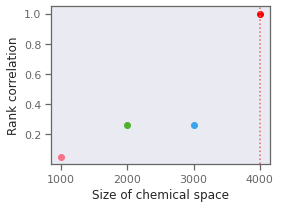

In [176]:
# Get subsets and calculate lime importances - subsample - get rank correlation
from scipy.stats import spearmanr
print('Baseline (full space):', baseline_set) #initially top 20
plt.figure(figsize=(4,3))
N = len(space)
size = np.arange(500,N,1000)
print(size)
# counts = {}
rank_corr = {N: 1}
colors = sns.color_palette("husl", len(size))
for i, f in enumerate(size):
    # subsample space
    rank_corr[f] = []
    for _ in range(10):
        idx = np.random.choice(np.arange(N), size=f, replace=False)
        subspace = [space[i] for i in idx]
        # get desc attributions
        ss_tstats, ss_beta = exmol.lime_explain(subspace, descriptor_type='MACCS')
        ss_imp = {a: b for a, b in zip(subspace[0].descriptors.descriptor_names, 
                                       ss_tstats) if not np.isnan(b)}
        
        ss_imp = dict(sorted(ss_imp.items(),
                     key=lambda item: abs(item[1]),
                     reverse=True))
        ss_set = [features[x] for x in ss_imp.keys()]
        
        ss_ohs = [0 if i not in ss_set else 1 for i in range(len(features))]
        ranks = {a:[b] for a,b in zip(baseline_set[:5], np.arange(1, 6))}
        for j, s in enumerate(ss_set):
            if s in ranks:
                ranks[s].append(j+1)
        print(ranks)
        r = spearmanr(np.arange(1, 6), [ranks[x][1] for x in ranks])
        rank_corr[f].append(r.correlation)

#         plt.scatter(f, c, color=colors[i], marker='o')
    plt.scatter(f, np.mean(rank_corr[f]), color=colors[i], marker='o')

plt.scatter(N, 1., color='red', marker='o')
plt.axvline(x=N, linestyle=':')
plt.xlabel('Size of chemical space')
plt.ylabel('Rank correlation')
plt.tight_layout()
plt.savefig('rank correlation.svg', dpi=300, bbox_inches='tight')

## Figure showing effect of mutation number, alphabet and size of chemical space


In [38]:
from rdkit.Chem.Draw import MolToFile, MolToSVG
smi = MolFromSmiles(soldata.SMILES[3000])
MolToFile(smi, 'mol_params.svg')

🤘Done🤘: 100%|██████████| 1100.0/1100 [00:02<00:00, 500.45it/s]                      

mut=1 T = 1.9776002621570996



/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply
🤘Done🤘: 100%|██████████| 1888.0/1888 [00:05<00:00, 360.39it/s]                      

mut=2 T = 1.9844040397667864



/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply
🤘Done🤘: 100%|██████████| 2085.0/2085 [00:05<00:00, 363.11it/s]                      

mut=3 T = 2.008919892366097



/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in sqrt
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply


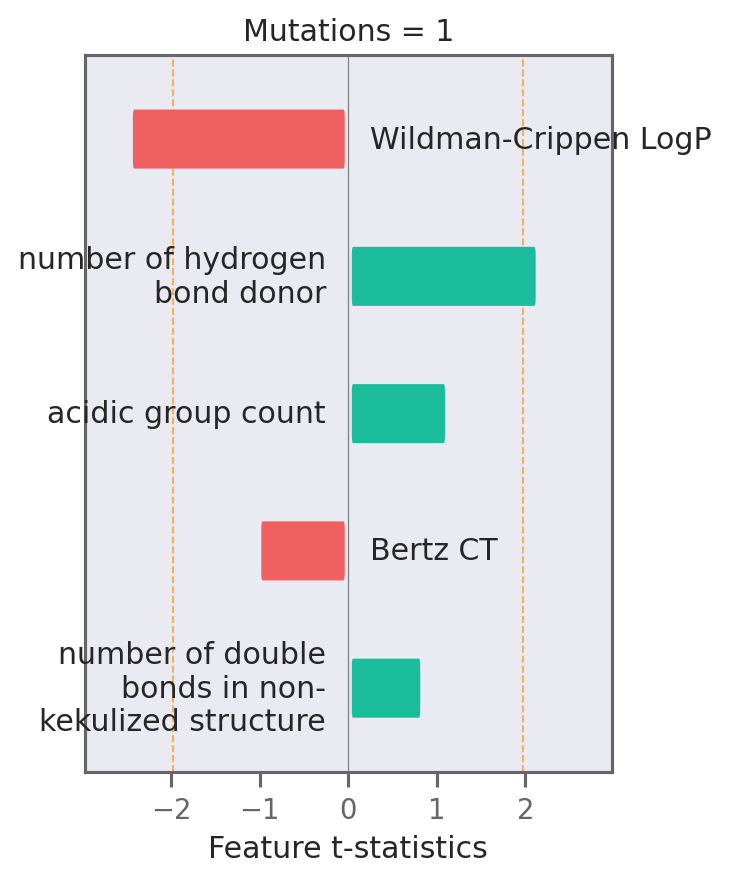

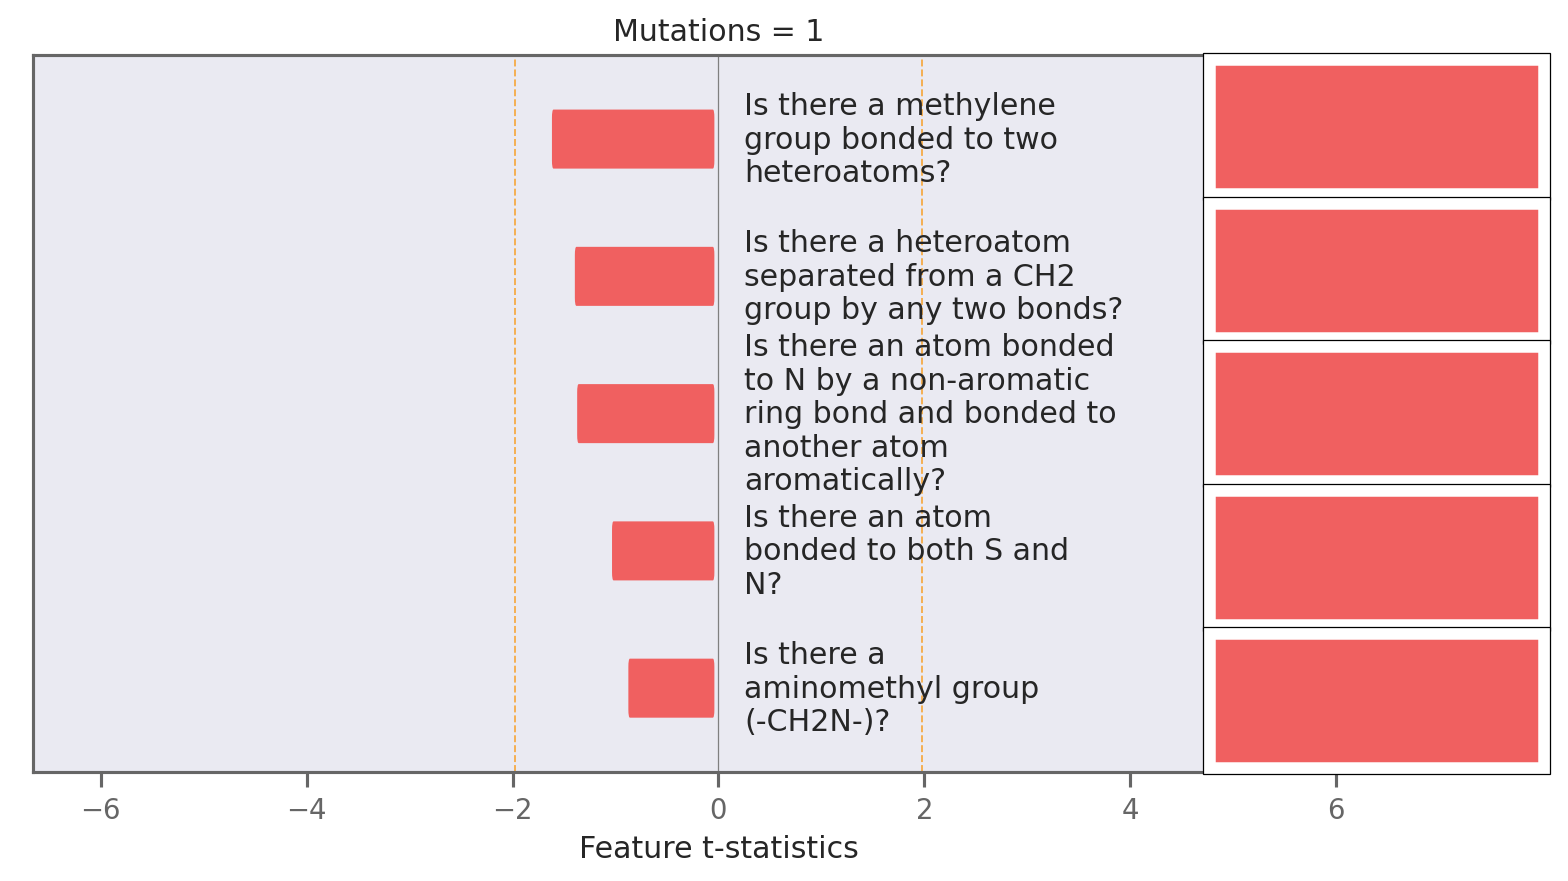

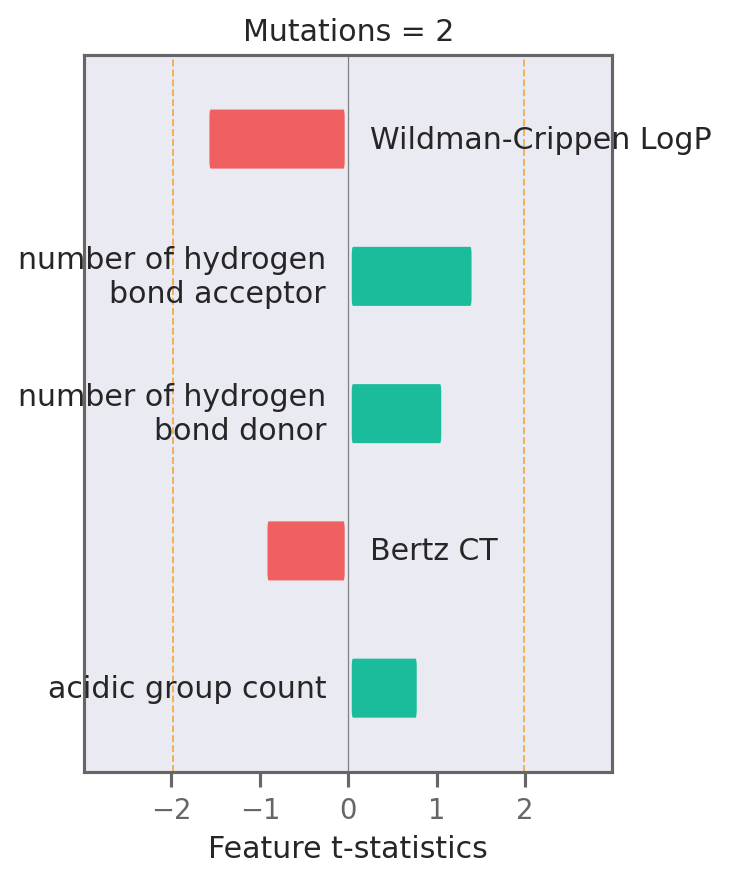

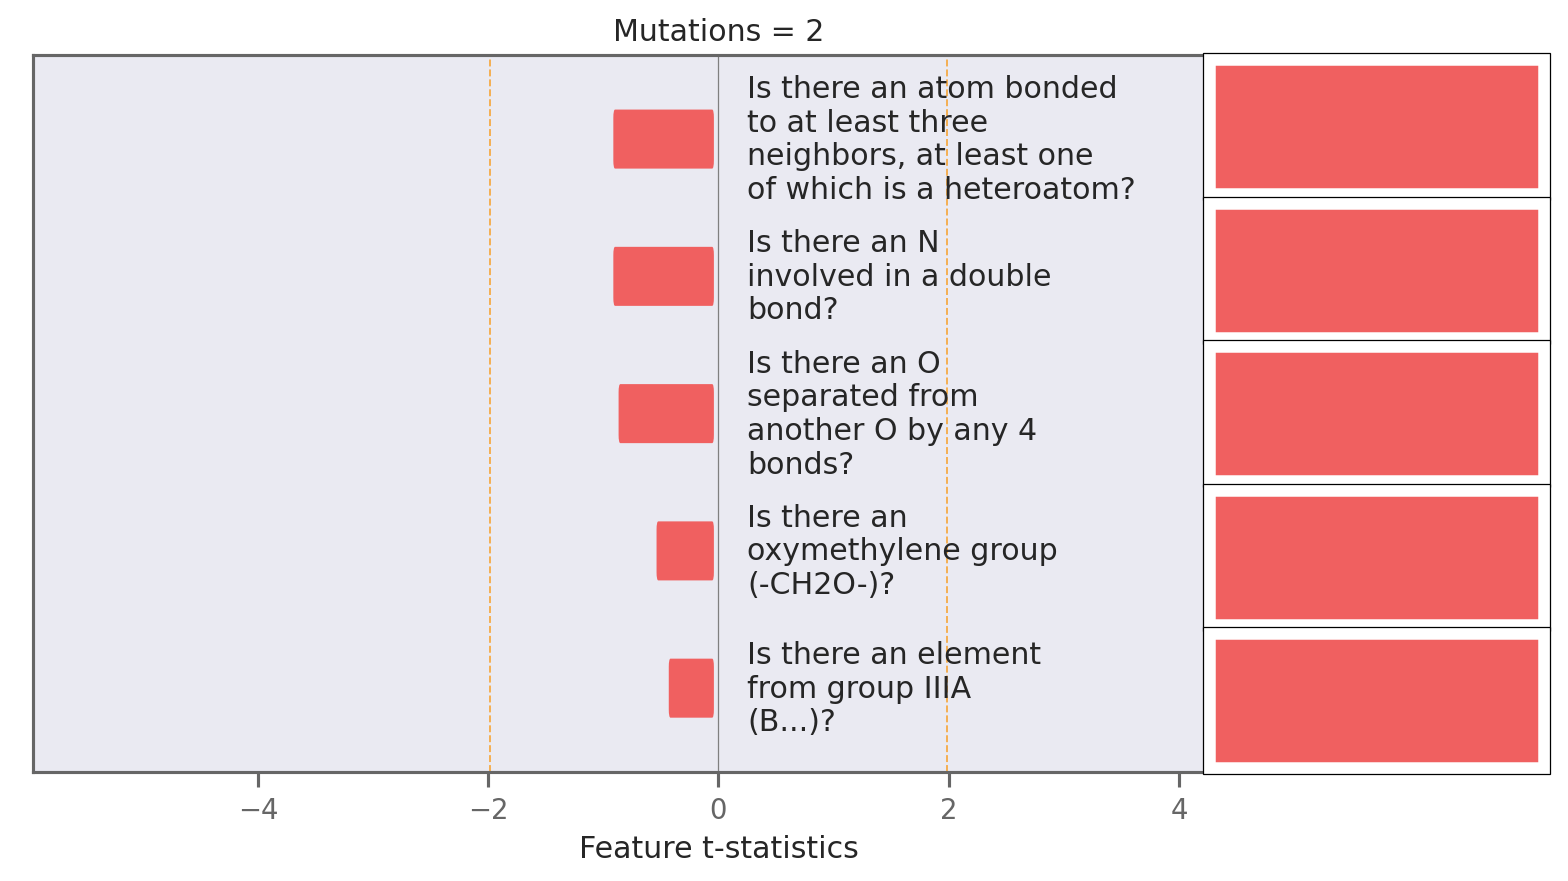

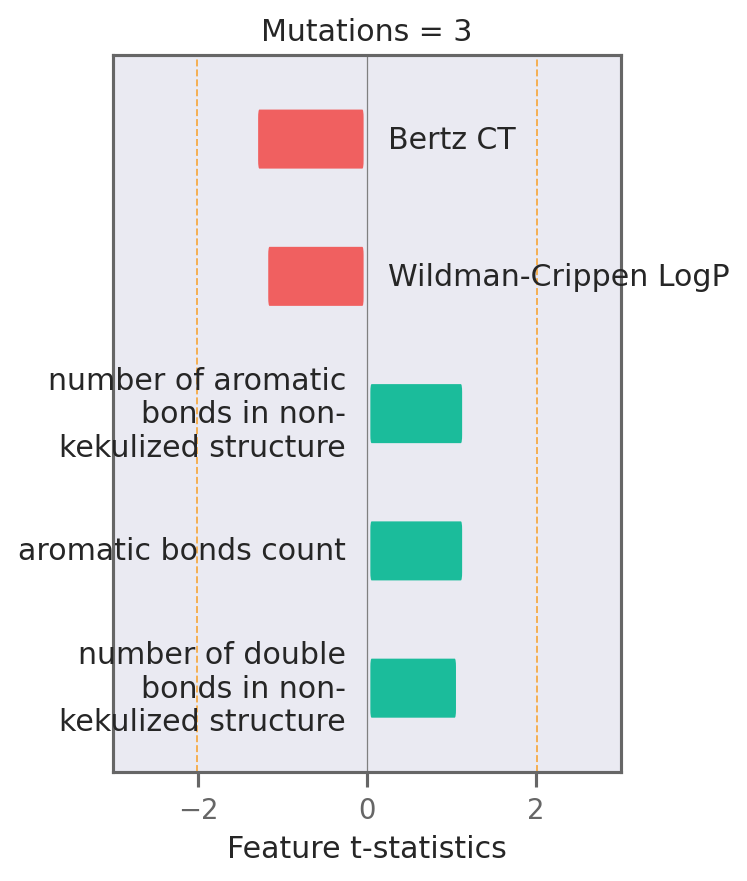

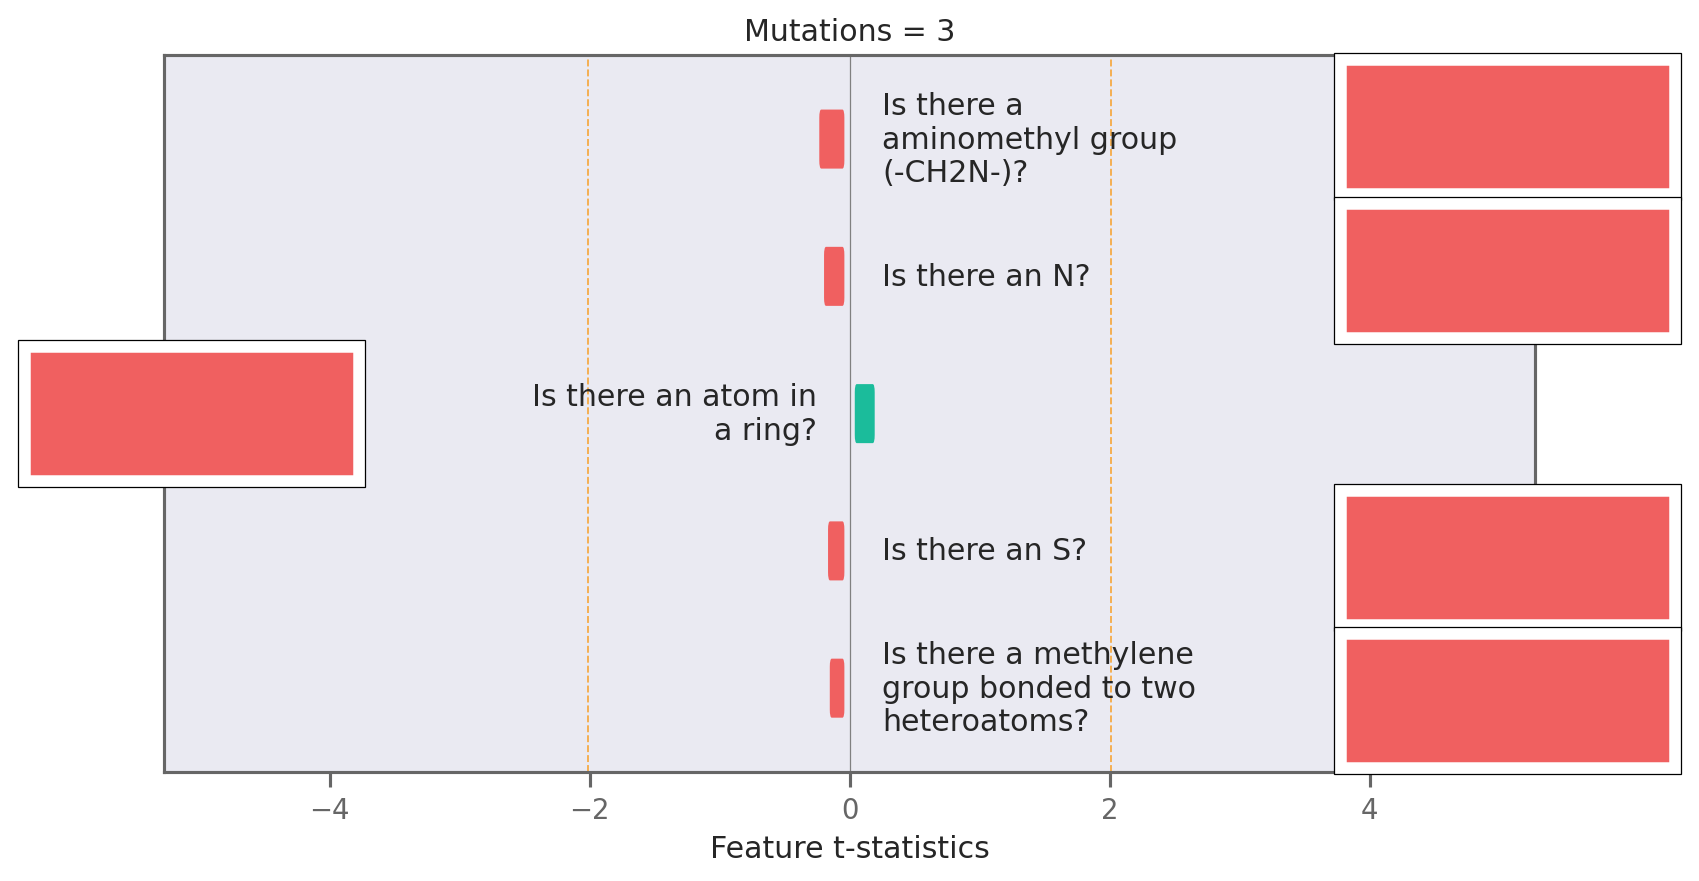

In [39]:
# Mutation

smi = soldata.SMILES[3000]
# tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
# spaces = {'Classic':[], 'MACCS': []}
desc_type = ['Classic', 'MACCS']
muts = [1,2,3]
for i in muts:
    stoned_kwargs={'num_samples': 2500, 'alphabet':exmol.get_basic_alphabet(),'min_mutations':i, 'max_mutations': i}
    space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
    # compute significant t-stat
    w = np.array([1/(1 + (1/(e.similarity + 0.000001) - 1)**5) for e in space])
    effective_n = np.sum(w) ** 2 / np.sum(w ** 2)
    T = ss.t.ppf( 0.975, df = effective_n)
    print(f'mut={i} T = {T}')
    for d in desc_type:
        # get sample t-stats
        space_tstats, beta = exmol.lime_explain(space, descriptor_type=d)

        # Get feature importance
        feature_importance = {a: [b, j] for j, a, b in zip(np.arange(len(space[0].descriptors.descriptors)), 
                                                           space[0].descriptors.descriptor_names, 
                                                           space_tstats) if not np.isnan(b)}
        feature_importance = dict(sorted(feature_importance.items(),
                         key=lambda item: abs(item[1][0]),
                         reverse=True))
        # Plot
        if d == 'Classic':
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,5), dpi=180)
        else:
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5), dpi=180)
        plot_desc(feature_importance, d, output_file=f'desc_{d}_mut{i}.svg', 
                      ax=ax, title=f'Mutations = {i}', T=T)

🤘Done🤘: 100%|██████████| 1153.0/1153 [00:01<00:00, 650.84it/s]                      
🤘Done🤘: 100%|██████████| 1947.0/1947 [00:04<00:00, 409.39it/s]                      
🤘Done🤘: 100%|██████████| 2111.0/2111 [00:05<00:00, 409.15it/s]                      


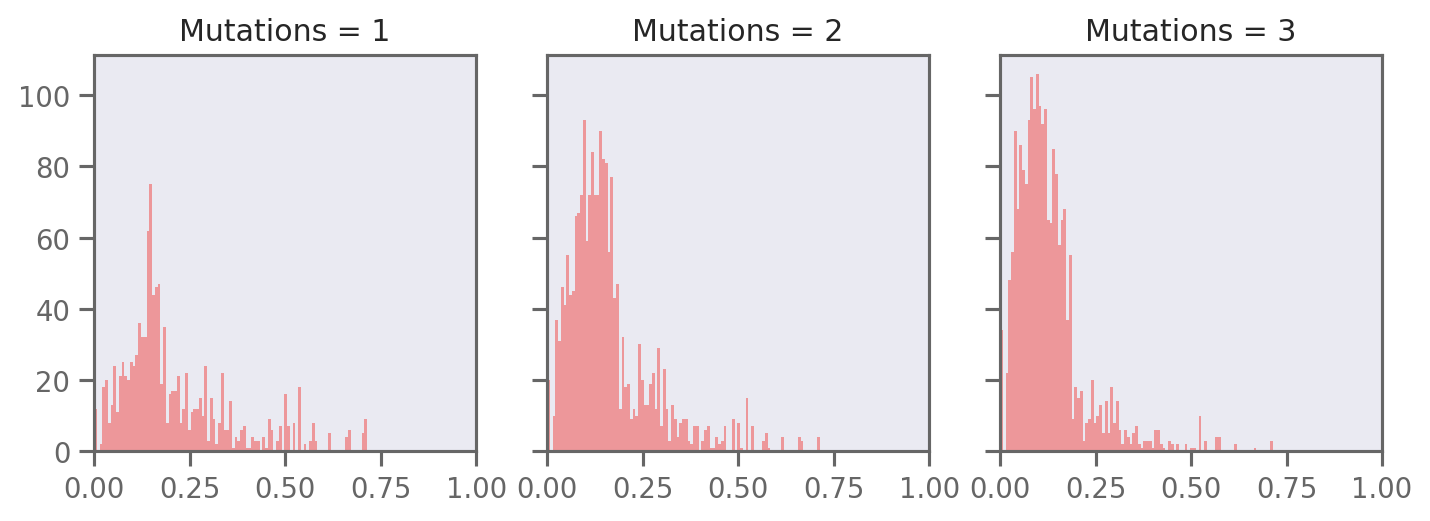

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(8,3), dpi=180, squeeze=True, sharey=True)
smi = soldata.SMILES[3000]
for i,n in enumerate([1,2,3]):
    stoned_kwargs={'num_samples': 2500, 'alphabet':exmol.get_basic_alphabet(),'min_mutations':n, 'max_mutations': n}
    space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)
    axs[i].hist([e.similarity for e in space[1:]], bins=99, edgecolor='none', label=d, alpha=0.6)
    axs[i].set_title(f'Mutations = {n}')
    axs[i].set_xlim(0,1)
# plt.legend()
plt.tight_layout()
plt.savefig('rnn-mutation-hist.png', bbox_inches='tight', dpi=180)

🤘Done🤘: 100%|██████████| 1600.0/1600 [00:04<00:00, 399.20it/s]                      

Alphabet=Basic T = 1.9816146991963282



/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply
🤘Done🤘: 100%|██████████| 1826.0/1826 [00:05<00:00, 357.68it/s]                      

Alphabet=Training Data T = 1.9687847297096257



/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply
🤘Done🤘: 100%|██████████| 1666.0/1666 [00:04<00:00, 401.97it/s]                      

Alphabet=SELFIES T = 1.9727836756753798



/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply


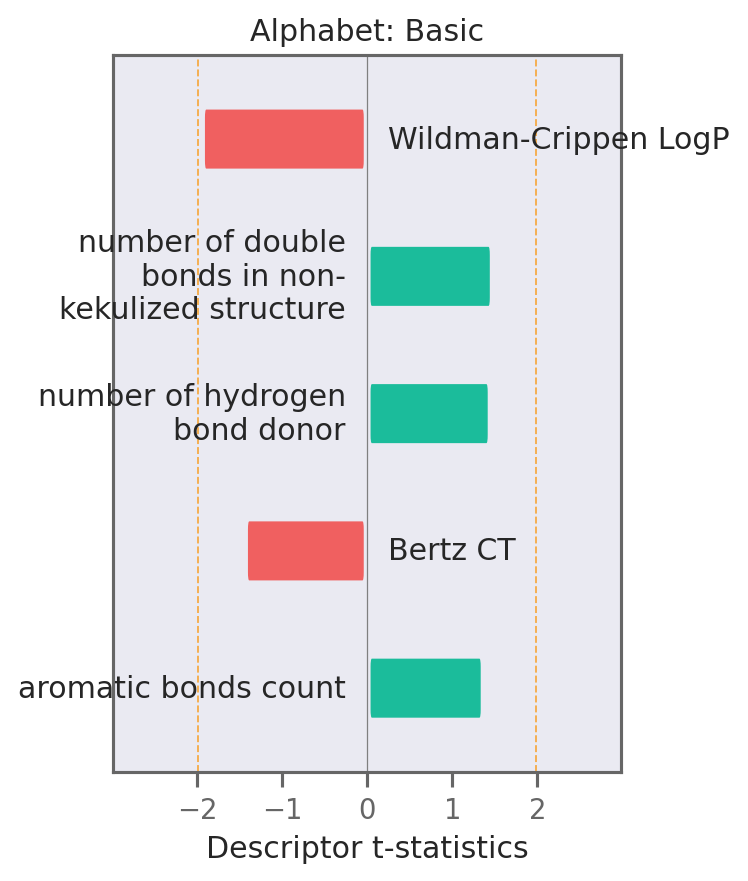

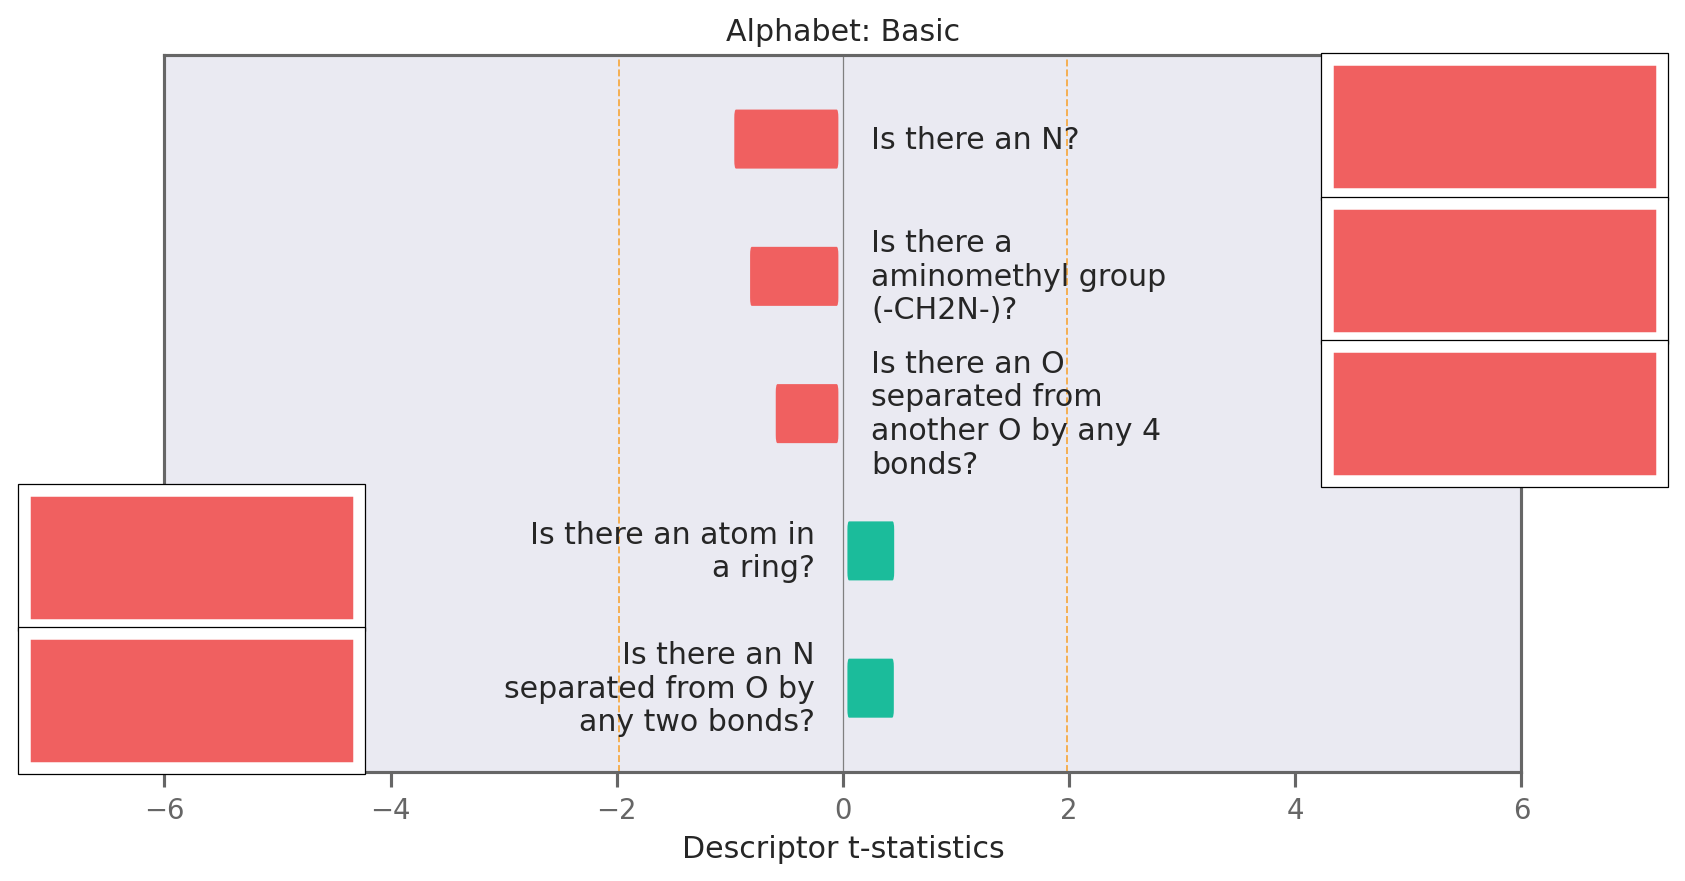

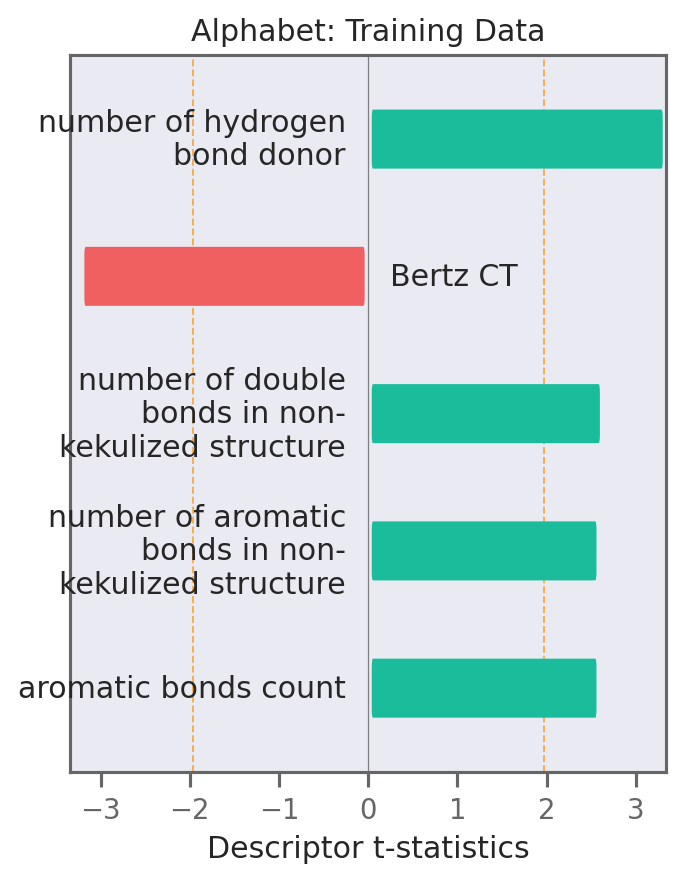

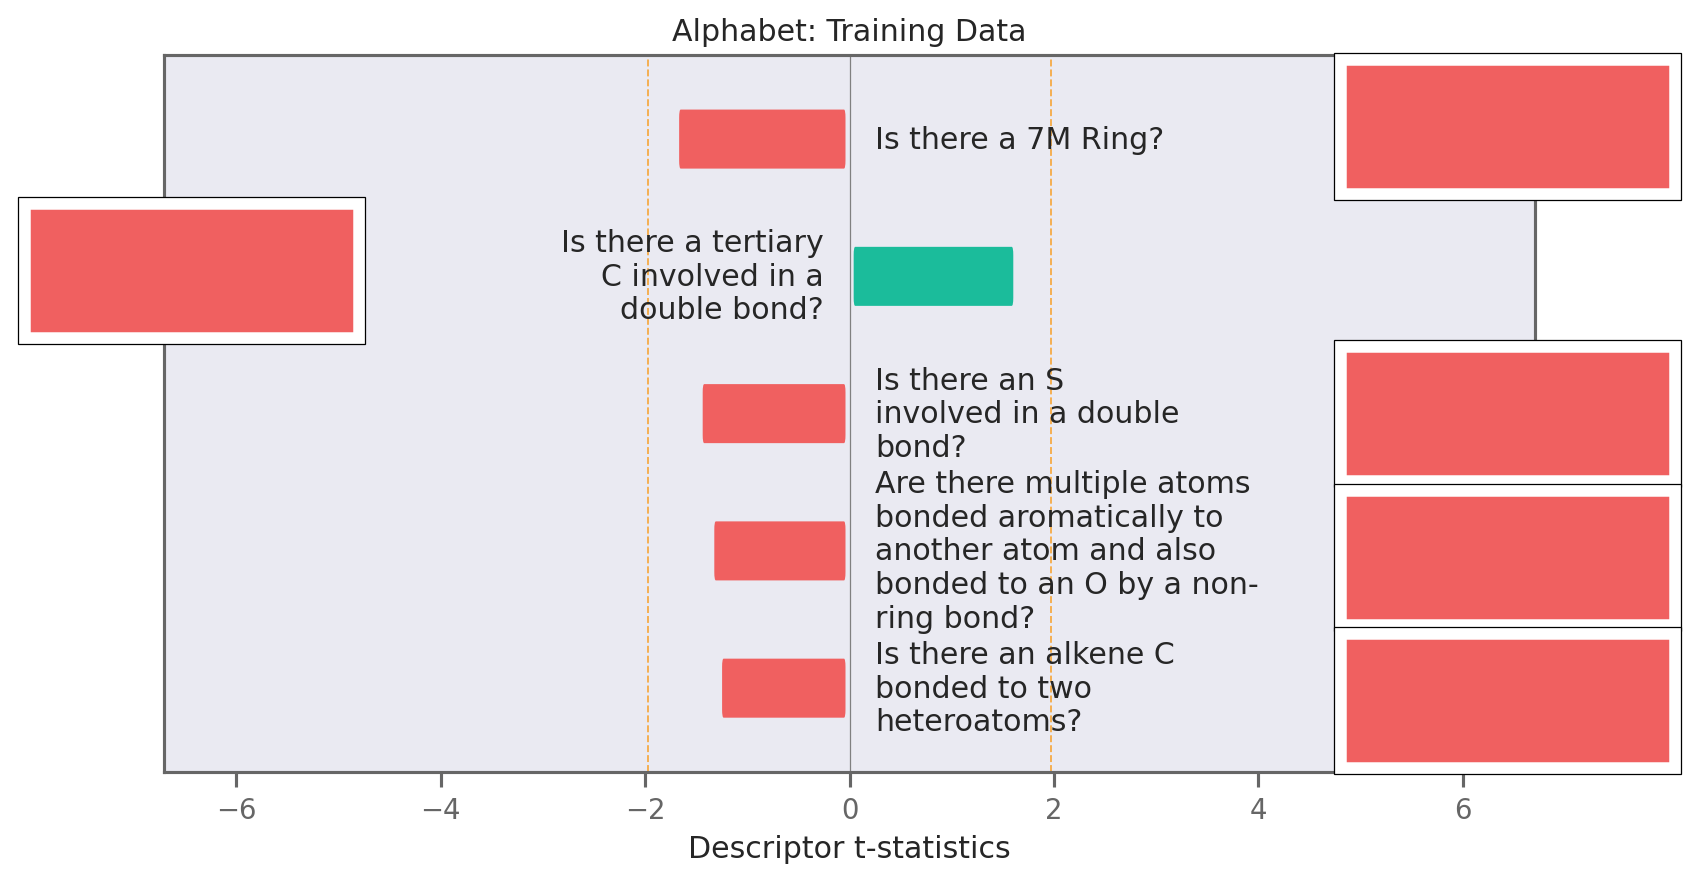

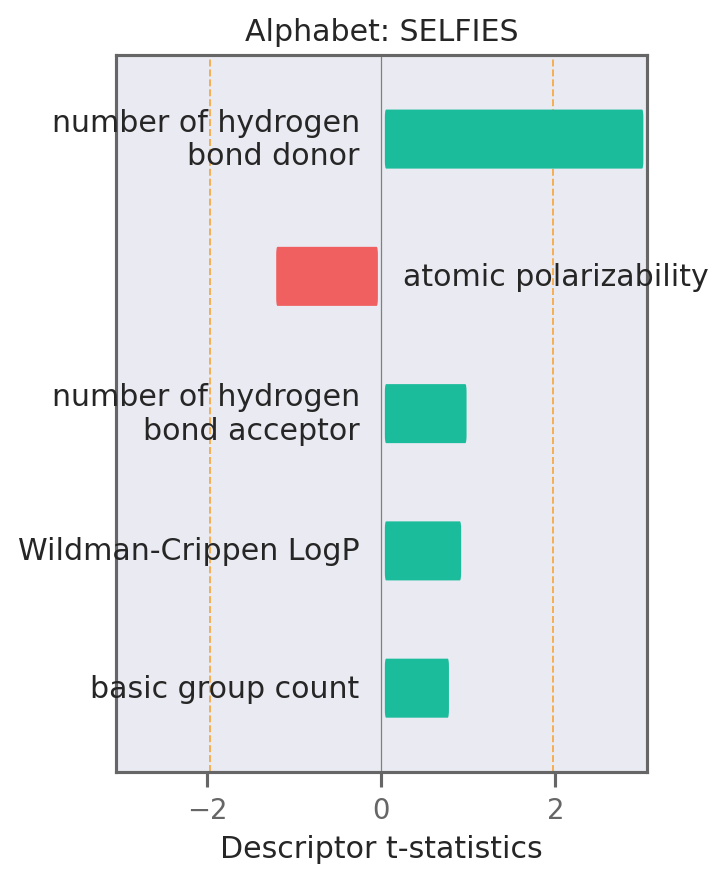

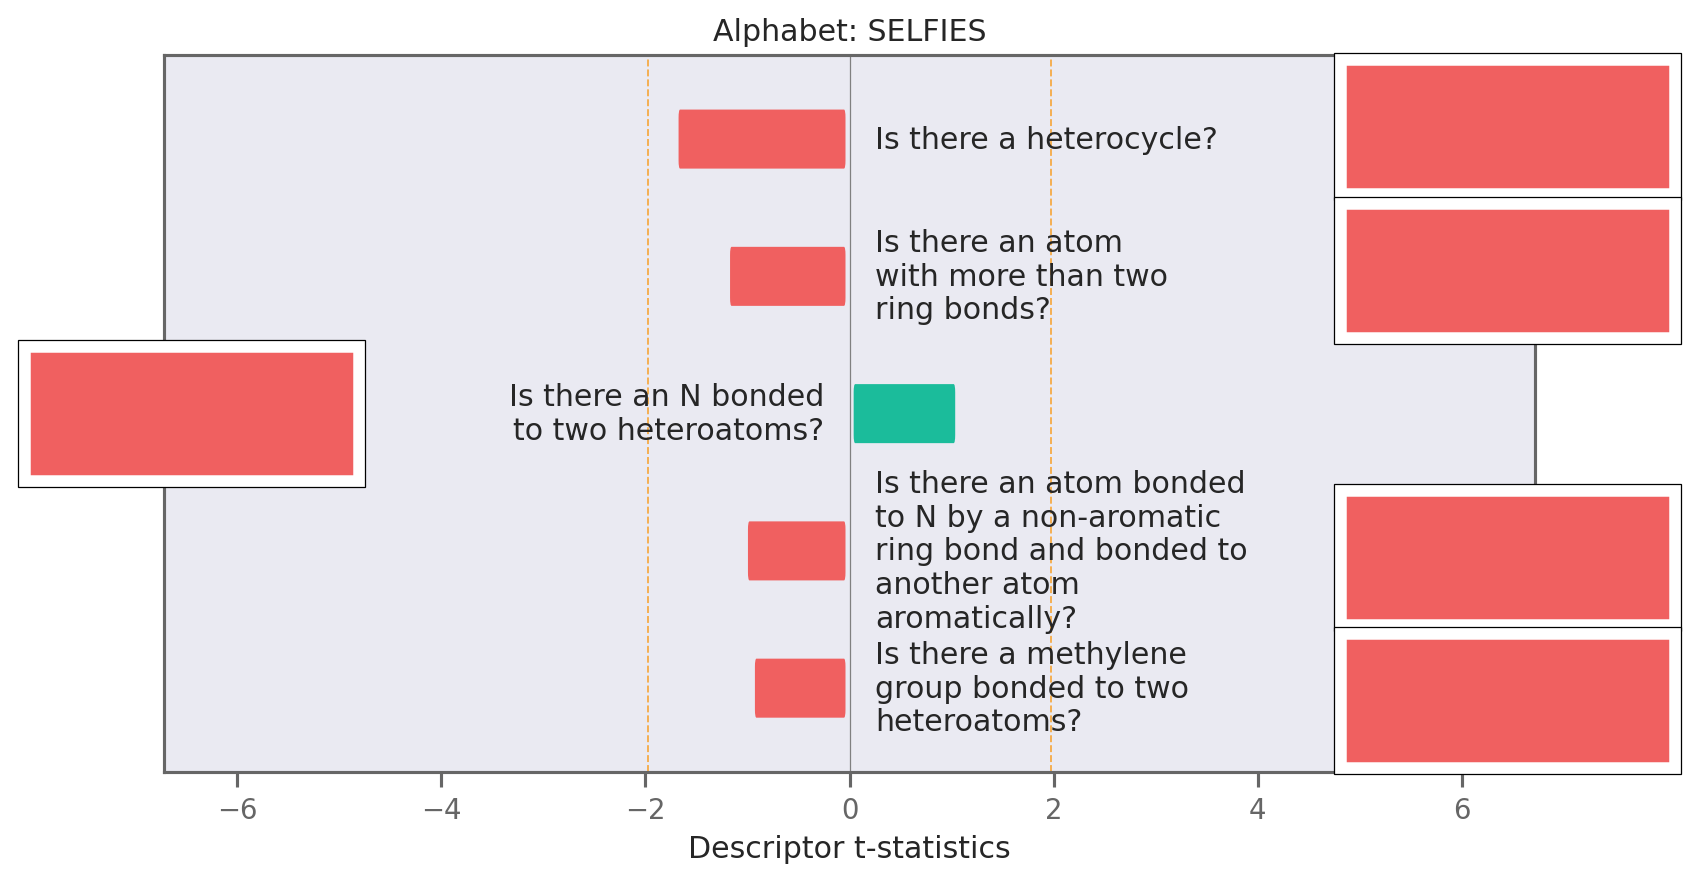

In [79]:
# Alphabet

basic = exmol.get_basic_alphabet()
train = sf.get_alphabet_from_selfies(selfies_list)
wide = sf.get_semantic_robust_alphabet()
desc_type = ['Classic', 'MACCS']
alphs = {'Basic': basic, 'Training Data': train, 'SELFIES': wide}

for a in alphs:
    stoned_kwargs={'num_samples': 2500, 'alphabet':alphs[a],'max_mutations':2}
    space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)    
    # compute significant t-stat
    w = np.array([1/(1 + (1/(e.similarity + 0.000001) - 1)**5) for e in space])
    effective_n = np.sum(w) ** 2 / np.sum(w ** 2)
    T = ss.t.ppf( 0.975, df = effective_n)
    print(f'Alphabet={a} T = {T}')
    for d in desc_type:
        # get sample t-stats
        space_tstats, beta = exmol.lime_explain(space, descriptor_type=d)

        # Get feature importance
        feature_importance = {a: [b, j] for j, a, b in zip(np.arange(len(space[0].descriptors.descriptors)), 
                                                           space[0].descriptors.descriptor_names, 
                                                           space_tstats) if not np.isnan(b)}
        feature_importance = dict(sorted(feature_importance.items(),
                         key=lambda item: abs(item[1][0]),
                         reverse=True))
        # Plot
        if d == 'Classic':
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,5), dpi=180)
        else:
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5), dpi=180)
        plot_desc(feature_importance, d, output_file=f'desc_{d}_alph_{a}.svg', 
                      ax=ax, title=f'Alphabet: {a}', T=T)


🤘Done🤘: 100%|██████████| 1033.0/1033 [00:01<00:00, 615.69it/s]                      

Chem space size=1500 T = 1.988169542369123


float32
float32


/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in multiply
🤘Done🤘: 100%|██████████| 1306.0/1306 [00:02<00:00, 605.73it/s]                      

Chem space size=2000 T = 1.9830076006980992


float32
float32


/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in multiply
🤘Done🤘: 100%|██████████| 1548.0/1548 [00:03<00:00, 476.74it/s]                      

Chem space size=2500 T = 1.9811086209520428


float32
float32


/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/gpfs/fs1/sfw2/python3/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in multiply


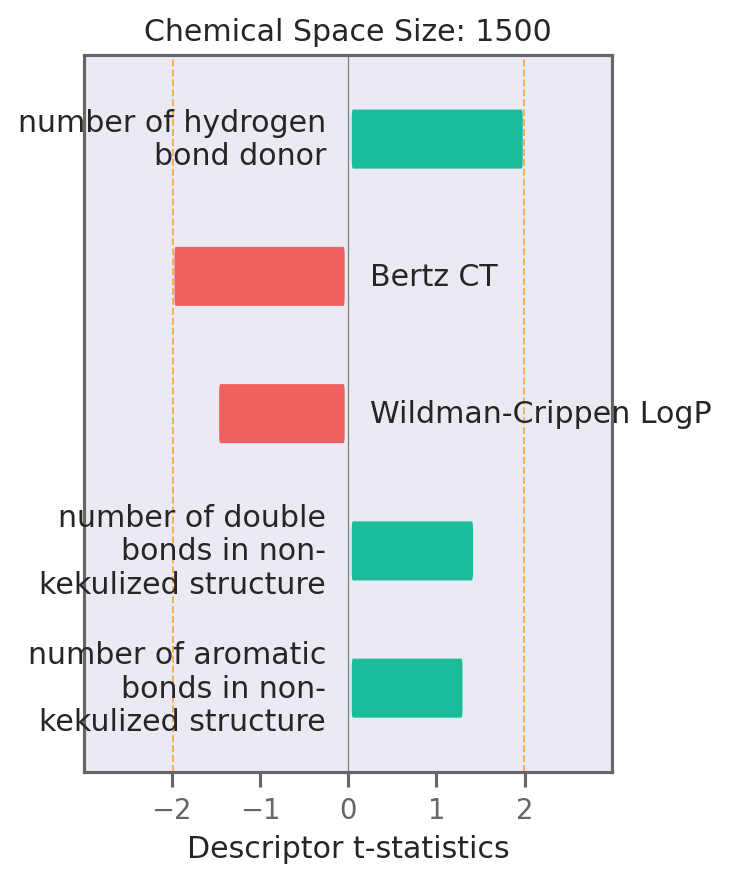

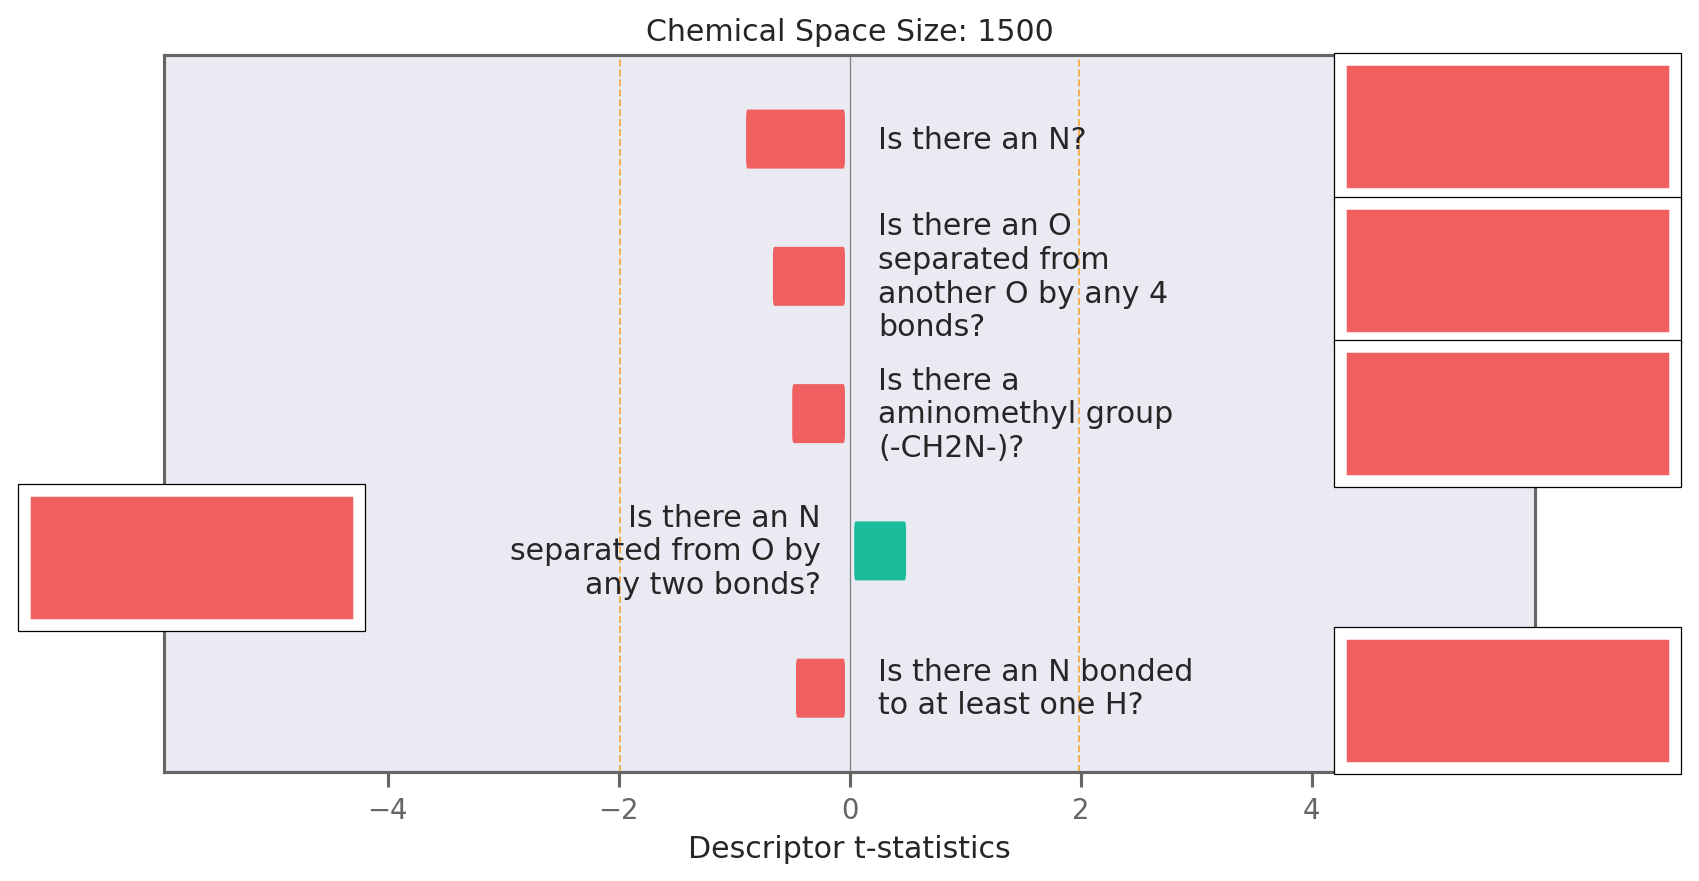

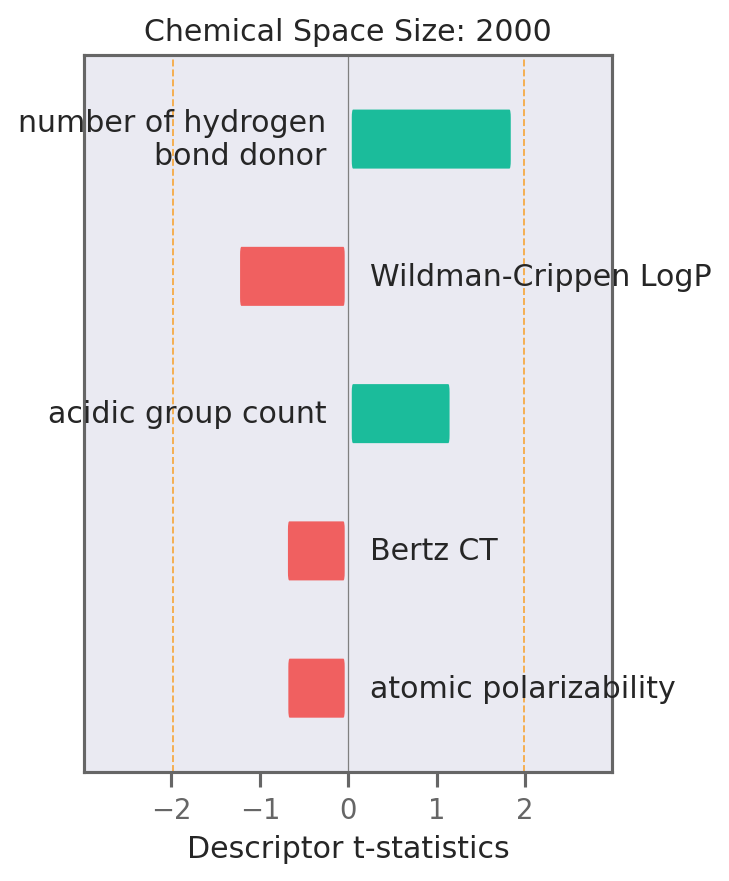

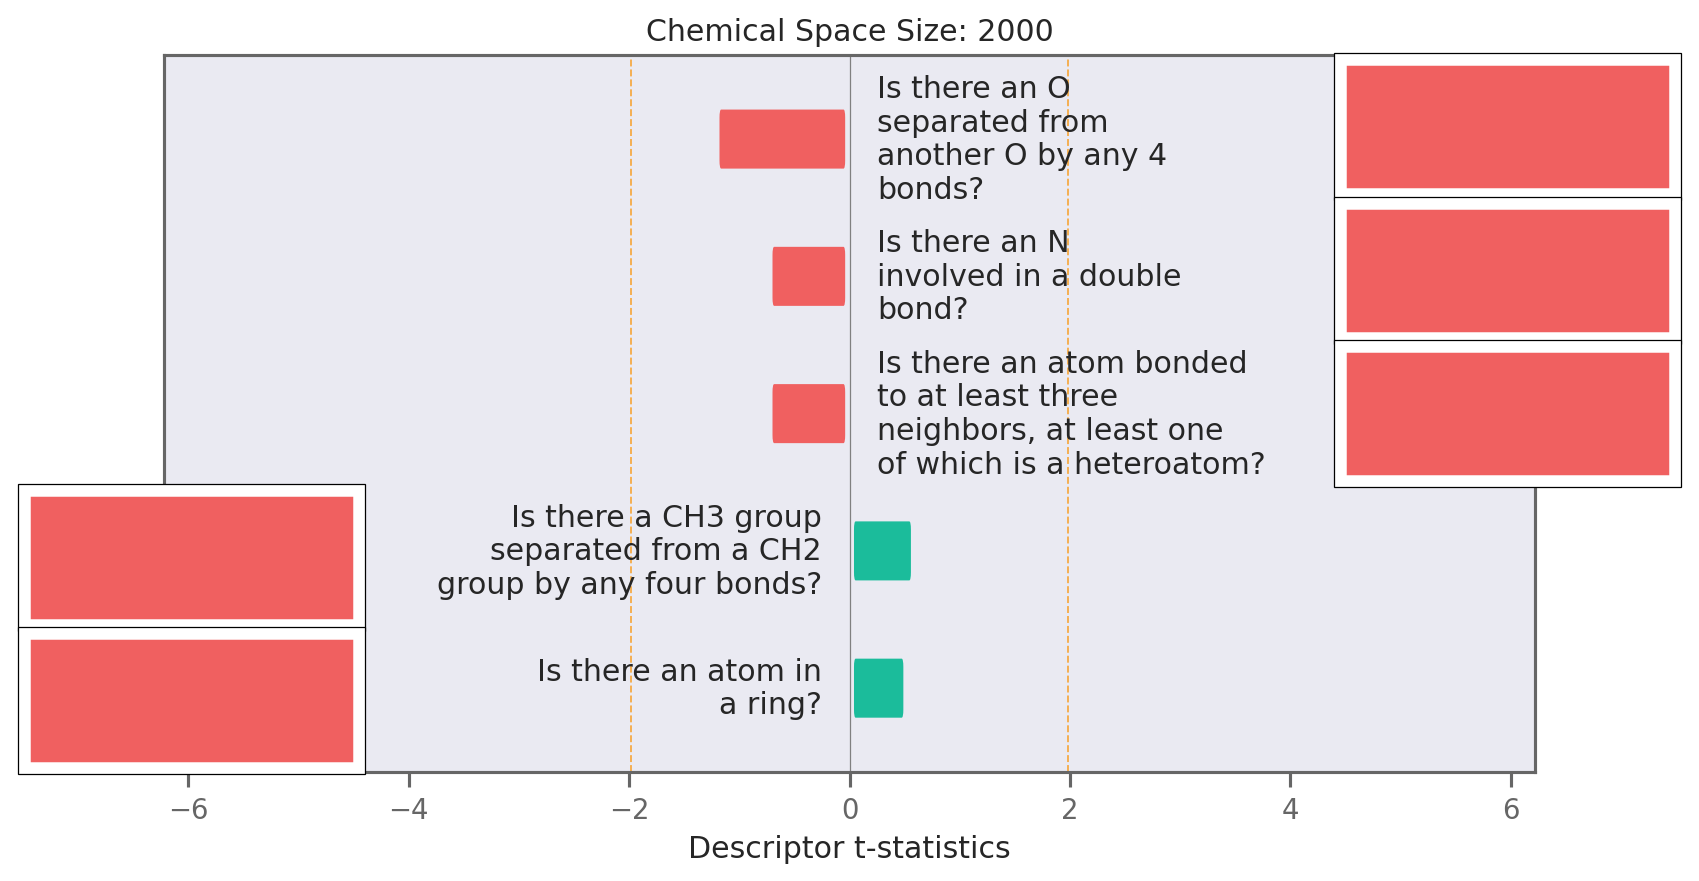

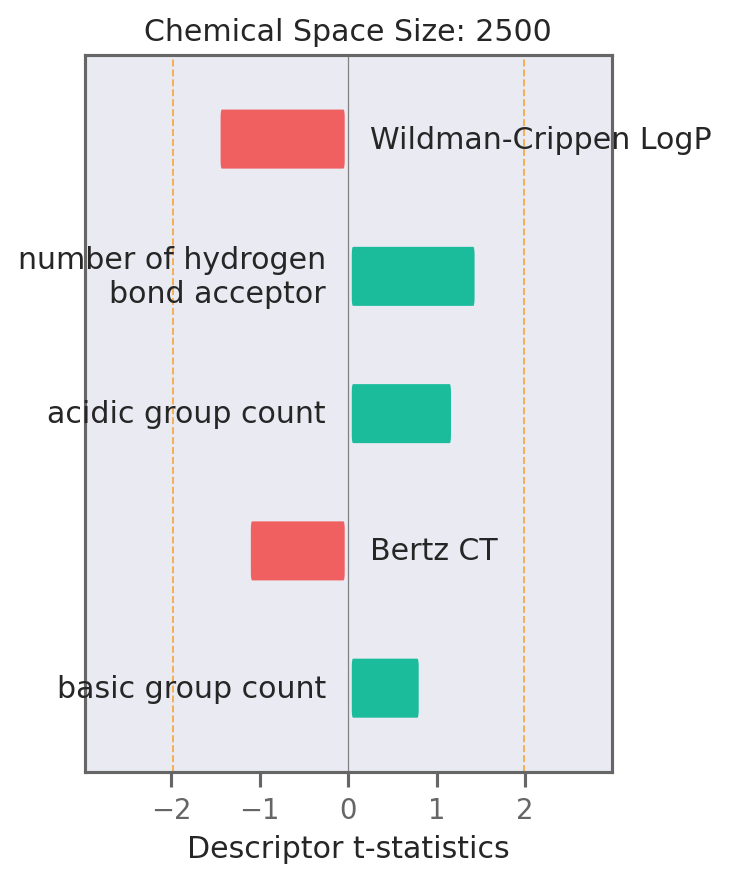

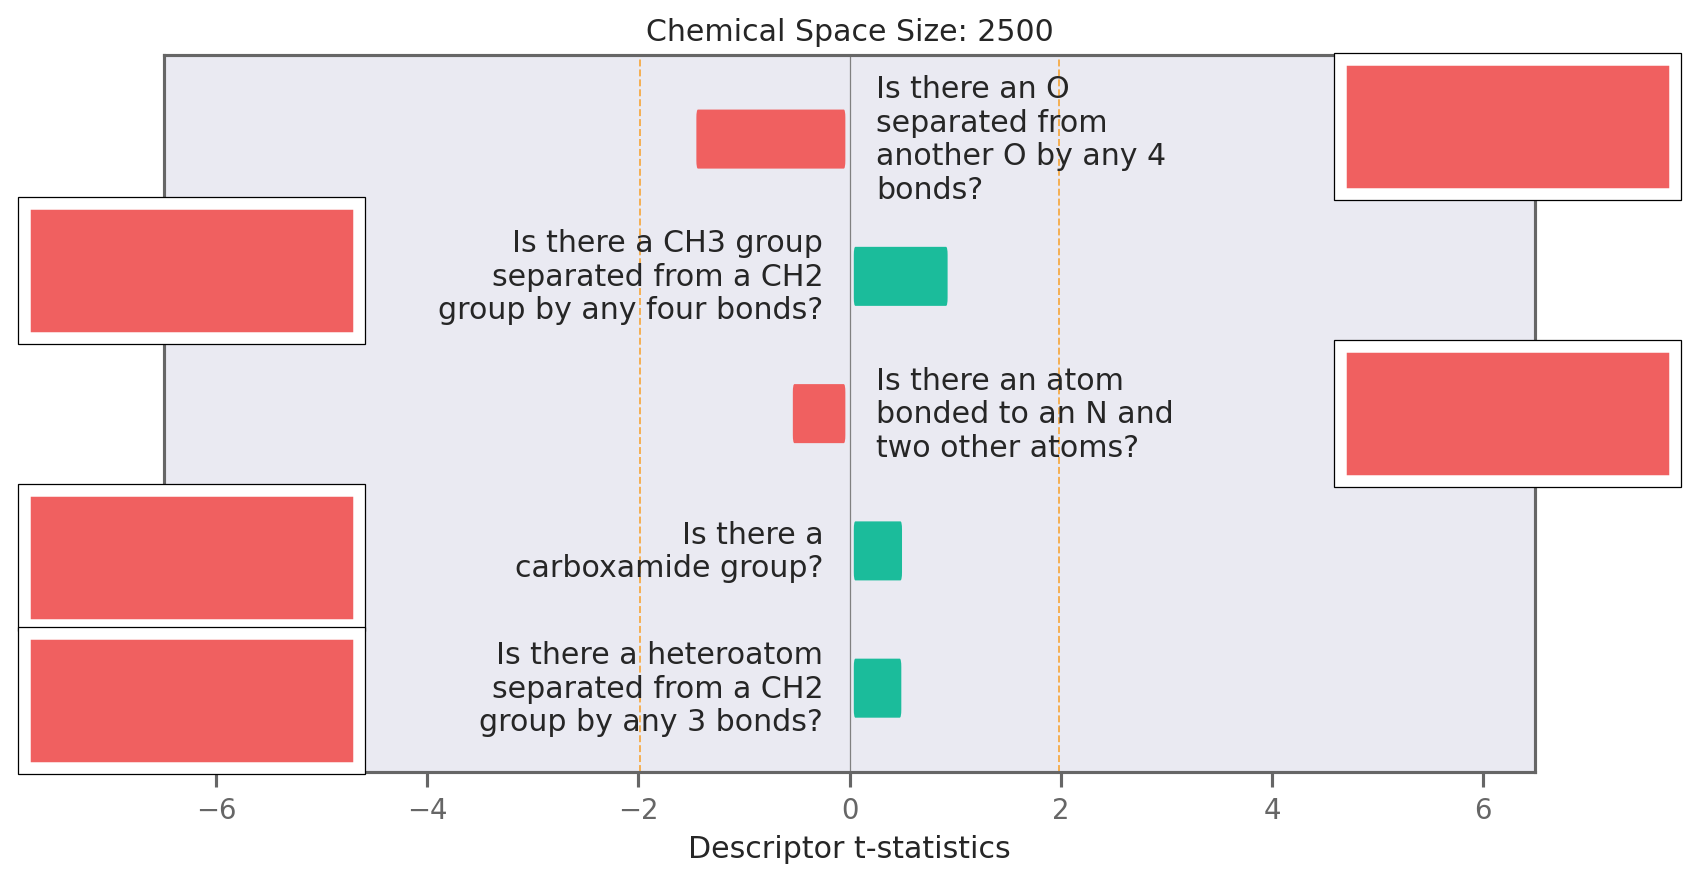

In [77]:
# Size of space

tstats, beta = {'Classic': [], 'MACCS': []}, {'Classic': [], 'MACCS': []}
spaces = {'Classic': [], 'MACCS': []}
desc_type = ['Classic', 'MACCS']
space_size = [1500, 2000, 2500]

for a in space_size:
    stoned_kwargs={'num_samples': a, 'alphabet': exmol.get_basic_alphabet(),'max_mutations':2}
    space = exmol.sample_space(smi, predictor_function, stoned_kwargs=stoned_kwargs)    
    # compute significant t-stat
    w = np.array([1/(1 + (1/(e.similarity + 0.000001) - 1)**5) for e in space])
    effective_n = np.sum(w) ** 2 / np.sum(w ** 2)
    T = ss.t.ppf( 0.975, df = effective_n)
    print(f'Chem space size={a} T = {T}')
    for d in desc_type:
        # get sample t-stats
        space_tstats, beta = exmol.lime_explain(space, descriptor_type=d)

        # Get feature importance
        feature_importance = {a: [b, j] for j, a, b in zip(np.arange(len(space[0].descriptors.descriptors)), 
                                                           space[0].descriptors.descriptor_names, 
                                                           space_tstats) if not np.isnan(b)}
        feature_importance = dict(sorted(feature_importance.items(),
                         key=lambda item: abs(item[1][0]),
                         reverse=True))
        # Plot
        if d == 'Classic':
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,5), dpi=180)
        else:
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5), dpi=180)
        plot_desc(feature_importance, d, output_file=f'desc_{d}_size_{a}.svg', 
                      ax=ax, title=f'Chemical Space Size: {a}', T=T)


## Miscellaneous cells

In [ ]:
## Functions to highlight molecules by significant smarts

from IPython.display import SVG
from rdkit.Chem import MolFromSmarts, Mol
from rdkit.Chem.Draw import rdDepictor, MolDrawOptions, rdMolDraw2D, MolToImage as mol2img
from collections import defaultdict
from matplotlib import colors, cm

def get_significant_SMARTS(example, tstats):
    descriptors = list(example.descriptors.descriptors)
    descriptor_names = list(example.descriptors.descriptor_names)
    maccs_smarts = pd.read_csv('../exmol/MACCSkeys.txt', sep='\t')
#     descriptor_smarts = {a:b for a,b in zip(descriptor_names, maccs_smarts['SMARTS'])}
    desc_list = []
    for t, d, s in zip(tstats, descriptor_names, maccs_smarts['SMARTS']):
        if t > 2.96:
            desc_list.append([s, float(t)])
    return desc_list

def get_highlight_lists(smi, descriptor_list):
    print(smi)
    aidx, bidx = [], []
    arads = {}
    highlight_atoms = defaultdict(list)
    highlight_bonds = defaultdict(list)
    count = 0
    mol = MolFromSmiles(smi)
    rdDepictor.Compute2DCoords(mol)
    for t in descriptor_list:
        print(t[0])
        patt = MolFromSmarts(t[0])
        rdDepictor.Compute2DCoords(patt)

        que_mc = Mol(mol.ToBinary())  # make a copy of the Mol object
        matching = que_mc.GetSubstructMatches(patt)
        matching = [a for b in matching for a in b]
        aidx.append(matching)

        for a in matching:
            highlight_atoms[a].append(cmap(normalizer(t[1])))
            arads[a] = 0.2
        if len(matching) > 1:
            count += 1
        if count > 5:
            break
    return aidx, highlight_atoms, arads
    
def draw_with_highlights(smi, highlight_atoms, arads, name='test.svg'):
    d = rdMolDraw2D.MolDraw2DSVG(1000, 300)
    dos = MolDrawOptions()
    dos.useBWAtomPalette()
    dos.minFontSize = 10
    dos.atomHighlightsAreCircles = False
    dos.fillHighlights=True
    d.SetDrawOptions(dos)
    d.DrawMoleculeWithHighlights(MolFromSmiles(smi), '', dict(highlight_atoms), {}, arads, {})
    d.FinishDrawing()

    img = d.GetDrawingText()
    with open(name, 'w+') as f:
        f.write(img)
    
    return d

space_tstats, beta = exmol.lime_explain(space, descriptor_type='MACCS')
cfs = exmol.rcf_explain(space, nmols=5)

normalizer = colors.Normalize(min(space_tstats), max(space_tstats))
cmap = cm.seismic
imgs = []
for i, m in enumerate(cfs):
    tstats = list(m.descriptors.descriptors) * beta
    descriptor_list = get_significant_SMARTS(m, tstats)
    descriptor_list.sort(key=lambda x: x[1], reverse=True)
    aidx, highlight_atoms, arads = get_highlight_lists(m.smiles, descriptor_list)
    imgs.append(draw_with_highlights(m.smiles, highlight_atoms, arads, name=f'm{i}.svg'))

In [ ]:
import skunk

fig, axs = plt.subplots(ncols=len(imgs))

# important line where we set ID
for i, im in enumerate(imgs):
    skunk.connect(axs[i], f'sk{i}')
    # Overwrite using file path to my svg
    # Can also use a string that contains the SVG 
    svg = skunk.insert(
        {
            f'sk{i}': f'm{i}.svg'
        })
plt.tight_layout()
skunk.display(svg)

# write to file
with open('replaced.png', 'w') as f:
    f.write(svg)
# or in jupyter notebook


In [ ]:
from rdkit.Chem import MolFromSmarts
smi = soldata.SMILES[100]
mol = MolFromSmiles(smi)
rdDepictor.Compute2DCoords(mol)

rdDepictor.Compute2DCoords(patt)

que_mc = Chem.Mol(mol.ToBinary())  # make a copy of the Mol object
matching = que_mc.GetSubstructMatch(patt)
que_mc

# matching = mol.GetSubstructMatch(patt)

In [ ]:
from rdkit.Chem.Draw import MolDrawOptions
from IPython.display import SVG

aidx, bidx = exmol.moldiff(mol, patt)

d = rdkit.Chem.Draw.rdMolDraw2D.MolDraw2DSVG(1000, 300)
dos = MolDrawOptions()
dos.useBWAtomPalette()
dos.minFontSize = 10
d.SetDrawOptions(dos)
d.DrawMolecule(mol, highlightAtoms=aidx,
               highlightBonds=bidx)
#                highlightAtomColors='cyan',
#                highlightBondColors='cyan')
d.FinishDrawing()
SVG(d.GetDrawingText())

img = d.GetDrawingText()
with open('test.svg', 'w+') as f:
    f.write(img)